# House Prices - Regression Predictions YData 2024    

**Team: Random Forest Rangers** ([Dmitry Gufranov](https://www.linkedin.com/in/gufranov/), [Evgenia Amineva](https://www.linkedin.com/in/janeami/), [Valeriya Vazhnova](https://www.linkedin.com/in/gufranov/))

### Import libraries

In [97]:
import pandas as pd 
import numpy as np 
import datetime

# vizualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# ml
from lightgbm import LGBMRegressor
import catboost as cb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler,  RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import optuna

In [98]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

### Loading the data

In [99]:
# load the train data
df = pd.read_csv('../data/train.csv')
display(df.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Preprocessing

In [100]:
from sklearn.base import BaseEstimator, TransformerMixin

class FillMissTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        df_upd = X.copy()

        if 'LotFrontage' in df_upd.columns:
            self.nb_lot = df_upd.groupby('Neighborhood')['LotFrontage'].mean()
        
        return self
    
    def fill_lot(self, x):
        if pd.notnull(x['LotFrontage']):
            return x['LotFrontage']
        else:
            return self.nb_lot.loc[x['Neighborhood']]

    def transform(self, X):
        df_upd = X.copy()

        # Fill columns where missing values have a meaning 'NA'
        feat_wn = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure',
           'BsmtFinType1', 'BsmtCond', 'BsmtQual']
        
        for c in feat_wn:
            df_upd[c].fillna('NA', inplace=True)

        # Fill columns where missing values have a meaning '0'
        feat_w0 = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
           'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'MasVnrArea']   #'GarageYrBlt'

        for c in feat_w0:
            df_upd[c].fillna(0, inplace=True)

        # Fill 'LotFrontage' with mean values grouped by 'Neighborhood'
        if 'LotFrontage' in df_upd.columns:
            df_upd['LotFrontage'] = df_upd.apply(self.fill_lot, axis=1)
            # df_upd['LotFrontage'] = df_upd.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
   

        # Fill missing numeric features with mean values
        num_si = SimpleImputer(strategy='mean')
        num_col = df_upd.select_dtypes(include=['int', 'float']).columns
        df_upd[num_col] = num_si.fit_transform(df_upd[num_col])

        # Fill missing categorical features with most frequent values
        cat_si = SimpleImputer(strategy='most_frequent')
        cat_col = df_upd.select_dtypes(include=['object']).columns
        df_upd[cat_col] = cat_si.fit_transform(df_upd[cat_col])

        return df_upd

In [101]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols_tdrop, num_cols_flag, rem_id):
        self.num_cols_tdrop = num_cols_tdrop
        self.num_cols_flag = num_cols_flag
        self.rem_id = rem_id
    
    def fit(self, X, y=None):
        # No need to fit anything for this transformer
        df_upd = X.copy()

        if 'OverallQual' in df_upd.columns and 'Neighborhood' in df_upd.columns:
            self.nb_qual = df_upd.groupby('Neighborhood')['OverallQual'].mean()

        return self
    
    def fill_nbgh(self, x):
        return self.nb_qual.loc[x['Neighborhood']]

    def transform(self, X):
        df_upd = X.copy()

        #Remove outliers
        df_upd = df_upd[~df_upd['Id'].isin(self.rem_id)]

        # Create new feature for bathrooms
        #df_upd['Bath'] = 0.225 * df_upd['BsmtFullBath'] + (-0.0121) * df_upd['BsmtHalfBath'] + 0.636 * df_upd['FullBath'] + 0.343 * df_upd['HalfBath']
        df_upd['Totalarea'] = df_upd['GrLivArea'] + df_upd['LotArea']
        #df_upd['Neighborhoodqual'] = df_upd.groupby('Neighborhood')['OverallQual'].transform('mean')
        df_upd['Neighborhoodqual'] = df_upd.apply(self.fill_nbgh, axis=1)

        # Drop columns
        df_upd = df_upd.drop(self.num_cols_tdrop, axis=1)

        # Flag transformation for numeric columns
        for c in self.num_cols_flag:
            if c in df_upd.columns:
                df_upd[c] = df_upd[c].apply(lambda x: 1 if x > 0 else 0)

        return df_upd

In [102]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols_oh, cat_cols_oe, cat_cols_tdrop):
        self.cat_cols_oh = cat_cols_oh
        self.cat_cols_oe = cat_cols_oe
        self.cat_cols_tdrop = cat_cols_tdrop
    
    def fit(self, X, y=None):
        # No need to fit anything for this transformer
        return self
    
    def transform(self, X):
        df_upd = X.copy()

        # Merge values in LotConfig
        if 'LotConfig' in df_upd.columns:
            df_upd.loc[df_upd['LotConfig']=='FR3', 'LotConfig'] = 'FR2'

        # Merge values in LandSlope
        if 'LandSlope' in df_upd.columns:
            df_upd.loc[df_upd['LandSlope']=='Sev', 'LandSlope'] = 'Mod'
            df_upd['GtlSlope'] = df_upd['LandSlope'].apply(lambda x: 1 if x=='Gtl' else 0)

        # Merge values in Condition1
        for cc in [['RRNn', 'RRAn'], ['RRNe', 'RRAe'], ['PosN', 'PosA']]:
            df_upd.loc[df_upd['Condition1']==cc[0], 'Condition1'] = cc[1]

        # Ordinal Encoding
        #oec = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']]) 
        oec = OrdinalEncoder(categories = [['Po', 'Fa', 'NA', 'TA', 'Gd', 'Ex']])     #better
        # oec = OrdinalEncoder(categories = [['Po', 'NA', 'Fa', 'TA', 'Gd', 'Ex']])     #the best or not
        for cc in self.cat_cols_oe:
            if cc in df_upd.columns:
                df_upd[cc] = oec.fit_transform(df_upd[[cc]])

        return df_upd.drop(self.cat_cols_tdrop, axis=1)

In [103]:
# class NormalizationTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, num_cols_norm):
#         self.num_cols_norm = num_cols_norm
    
#     def fit(self, X, y=None):
#         # No need to fit anything for this transformer
#         return self
    
#     def transform(self, X):
#         df_upd = X.copy()

#         # Normalizing
#         power = PowerTransformer(method='yeo-johnson', standardize=True)
#         df_upd[self.num_cols_norm] = power.fit_transform(df_upd[self.num_cols_norm])

#         return df_upd

class NormalizationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols_norm):
        self.num_cols_norm = num_cols_norm
        self.power = PowerTransformer(method='yeo-johnson', standardize=True)
    
    def fit(self, X, y=None):
        df_upd = X.copy()
        self.power.fit(df_upd[self.num_cols_norm])
        return self
    
    def transform(self, X):
        df_upd = X.copy()

        # Normalizing
        df_upd[self.num_cols_norm] = self.power.transform(df_upd[self.num_cols_norm])
        return df_upd

class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # No need to fit anything for this transformer
        return self
    
    def transform(self, X, y=None):
        return pd.get_dummies(X, columns=self.columns, dtype='int')

## Preprocessing 

In [104]:
# for linear models

cat_cols_oe = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']

cat_cols_oh = ['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', \
               'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', \
                'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence', 'SaleType', \
                'SaleCondition', 'MSSubClass', 'OverallCond', 'KitchenAbvGr', 'MoSold', 'YrSold']

cat_cols_tdrop = ['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'PoolQC', 'MiscFeature', 'MiscVal']

num_cols_norm = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', \
                 '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'Totalarea'] #'GrLivArea', 

num_cols_asis = ['OverallQual', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']

num_cols_tdrop = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'] #'1stFlrSF', '2ndFlrSF'

num_cols_flag = ['BsmtFinSF2', 'LowQualFinSF', '3SsnPorch', 'PoolArea']


#outliers
rem_id = [250, 314, 336, 496, 584, 935, 1299, 1329]

ifeatures = ['1stFlrSF', '2ndFlrSF', 'LotArea', 'TotalBsmtSF', 'OpenPorchSF',
       'BsmtFinSF1', 'GarageArea', 'YearRemodAdd', 'OverallQual', 'YearBuilt',
       'LotFrontage', 'BsmtUnfSF', 'GarageYrBlt', 'MasVnrArea', #'Bath',
       'WoodDeckSF', 'EnclosedPorch', 'CentralAir_N', 'HeatingQC',
       'KitchenQual', 'OverallCond_5.0', 'SaleCondition_Normal', 'FireplaceQu',
       'GarageCars', 'OverallCond_3.0', 'OverallCond_4.0', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'SaleCondition_Abnorml', 'MSZoning_RL',
       'Functional_Typ', 'BsmtExposure_Gd', 'Condition1_Norm', 'ScreenPorch',
       'BsmtCond', 'OverallCond_7.0', 'BsmtQual', 'ExterCond',
       'Neighborhood_Crawfor', 'YrSold_2009.0', 'Exterior1st_BrkFace',
       'BsmtExposure_No', 'GarageQual', 'GarageType_Attchd',
       'Neighborhood_Edwards', 'ExterQual', 'MoSold_12.0', 'YrSold_2006.0',
       'Neighborhood_BrkSide', 'Neighborhood_IDOTRR', 'MSZoning_RM',
       'Fireplaces', 'LotShape_IR1', 'Neighborhood_OldTown',
       'Condition1_Artery', 'YrSold_2007.0', 'Electrical_FuseA', 'SaleType_WD',
       'BsmtFinType1_ALQ', 'SaleType_New', 'Neighborhood_StoneBr',
       'GarageType_Detchd', 'LotConfig_CulDSac', 'Neighborhood_NAmes',
       'BsmtFinType1_Rec', 'MSSubClass_30.0', 'GarageCond', 'KitchenAbvGr_1.0',
       'BsmtFinType1_GLQ', 'BldgType_1Fam', 'Neighborhood_Somerst',
       'BsmtFinType2_BLQ', 'GarageFinish_Fin', 'LotConfig_FR2', 'GrLivArea', 'Totalarea', 'Neighborhoodqual']

col_tdrop_linm = ['ExterQual', 'LotShape_IR1', 'TotRmsAbvGrd', 'MSZoning_Rm', 'GarageCond', 'GarageCars', 'SaleType_New', 'GarageType_Detchd']

rst = 44

In [105]:
# Define  pipeline with all transformers

pipeline = Pipeline([
    ('fill_miss', FillMissTransformer()),  # Fill missing values
    ('feat_eng', FeatureEngineeringTransformer(num_cols_tdrop, num_cols_flag, rem_id)),  # Feature engineering
    ('normalization', NormalizationTransformer(num_cols_norm)),  # Normalization
    ('categorical_transformer', CategoricalTransformer(cat_cols_oh, cat_cols_oe, cat_cols_tdrop)),  # Categorical transformation
    ('get_dummies', GetDummiesTransformer(columns=cat_cols_oh)),  # One-hot encoding
    # ('normalization', NormalizationTransformer(num_cols_norm + cat_cols_oe))  # Normalization
])

pipeline

Pipeline(steps=[('fill_miss', FillMissTransformer()),
                ('feat_eng',
                 FeatureEngineeringTransformer(num_cols_flag=['BsmtFinSF2',
                                                              'LowQualFinSF',
                                                              '3SsnPorch',
                                                              'PoolArea'],
                                               num_cols_tdrop=['BsmtFullBath',
                                                               'BsmtHalfBath',
                                                               'FullBath',
                                                               'HalfBath'],
                                               rem_id=[250, 314, 336, 496, 584,
                                                       935, 1299, 1329])),
                ('normalization',
                 NormalizationTransformer(num_cols_norm=['LotFrontage',
                                                         'Lot...
                                                'LandContour', 'LotConfig',
                                                'Neighborhood', 'Condition1',
                                                'BldgType', 'HouseStyle',
                                                'RoofStyle', 'Exterior1st',
                                                'Exterior2nd', 'MasVnrType',
                                                'Foundation', 'BsmtExposure',
                                                'BsmtFinType1', 'BsmtFinType2',
                                                'Heating', 'CentralAir',
                                                'Electrical', 'Functional',
                                                'GarageType', 'GarageFinish',
                                                'PavedDrive', 'Fence',
                                                'SaleType', 'SaleCondition',
                                                'MSSubClass', 'OverallCond',
                                                'KitchenAbvGr', ...]))])

In [106]:
# prepare train / validation
tdf = df.copy()

tdf = pipeline.fit_transform(tdf)

label = np.log1p(tdf['SalePrice'])
tdf.drop(['Id', 'SalePrice'], axis=1, inplace=True)
tdf = tdf[ifeatures]

In [107]:
test_data = pd.read_csv('../data/test.csv')

# test_data = pipeline.fit_transform(test_data)
test_data = pipeline.transform(test_data)

t_id = test_data['Id']
test_data.drop('Id', axis=1, inplace=True)
test_data = test_data[ifeatures]

In [108]:
# # if commented out ifeatures, need to make sure columns are the same in train and test

# diff_cols = set(tdf.columns).symmetric_difference(set(test_data.columns))
# tdf = tdf[list(set(tdf.columns).difference(diff_cols))]
# test_data = test_data[list(set(test_data.columns).difference(diff_cols))]

# assert (tdf.columns == test_data.columns).all()


## Model construction

In [109]:
X_train, X_test, y_train, y_test = train_test_split(tdf, label, test_size=0.25, random_state=rst)
models_train_pred = pd.DataFrame()
models_test_pred = pd.DataFrame()
results = pd.DataFrame(index=['RMSE', 'R2'])

# optuna
optuna_train_pred = pd.DataFrame()
optuna_test_pred = pd.DataFrame()
optuna_results = pd.DataFrame(index=['RMSE', 'R2'])

### Linear models

In [110]:
model = Ridge()

# params_lasso = {'alpha': np.arange(2, 25, 1), 'max_iter': [500, 1000, None], 'random_state': [rst]}
params_lasso = {'alpha': [22], 'max_iter': [1000], 'random_state': [rst]}

gs_alg = GridSearchCV(model, param_grid = params_lasso, cv = 10, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

# Ridge(alpha=22, max_iter=1000, random_state=44)
# Testing performance
# RMSE: 0.104
# R2: 0.930 

Ridge(alpha=22, max_iter=1000, random_state=44)
Testing performance
RMSE: 0.104
R2: 0.930 



In [111]:
# Optuna + Ridge study

def objective(trial):
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 100.0),
        'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 
                                                      'sparse_cg', 'sag', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 100, 5000),
#         'random_state': trial.suggest_int('random_state', 50, 100)
    }
    
    model = Ridge(**params, random_state=rst)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(f'Best RMSE: {study.best_trial.value}')

[I 2024-02-18 01:07:49,098] A new study created in memory with name: no-name-dc568c52-43df-4164-b55d-f4b57210ccb0
[I 2024-02-18 01:07:49,167] Trial 0 finished with value: 0.10774537612313773 and parameters: {'alpha': 0.12083504117439965, 'solver': 'sparse_cg', 'max_iter': 1196}. Best is trial 0 with value: 0.10774537612313773.
[I 2024-02-18 01:07:49,195] Trial 1 finished with value: 0.10698663382822074 and parameters: {'alpha': 1.7998759466911007, 'solver': 'svd', 'max_iter': 2118}. Best is trial 1 with value: 0.10698663382822074.
[I 2024-02-18 01:07:49,260] Trial 2 finished with value: 0.10751281867152243 and parameters: {'alpha': 0.3241525234875811, 'solver': 'lsqr', 'max_iter': 4413}. Best is trial 1 with value: 0.10698663382822074.
[I 2024-02-18 01:07:49,288] Trial 3 finished with value: 0.10821333239665347 and parameters: {'alpha': 0.00010740778878312203, 'solver': 'svd', 'max_iter': 3665}. Best is trial 1 with value: 0.10698663382822074.
[I 2024-02-18 01:07:52,602] Trial 4 finish

[I 2024-02-18 01:08:04,038] Trial 39 finished with value: 0.10431676696499588 and parameters: {'alpha': 31.151443280364084, 'solver': 'svd', 'max_iter': 1481}. Best is trial 39 with value: 0.10431676696499588.
[I 2024-02-18 01:08:04,079] Trial 40 finished with value: 0.10445565215438701 and parameters: {'alpha': 44.06880674896691, 'solver': 'svd', 'max_iter': 976}. Best is trial 39 with value: 0.10431676696499588.
[I 2024-02-18 01:08:04,113] Trial 41 finished with value: 0.10432701235359304 and parameters: {'alpha': 26.812655226380688, 'solver': 'svd', 'max_iter': 975}. Best is trial 39 with value: 0.10431676696499588.
[I 2024-02-18 01:08:04,149] Trial 42 finished with value: 0.10652336834324853 and parameters: {'alpha': 3.033005165229072, 'solver': 'svd', 'max_iter': 999}. Best is trial 39 with value: 0.10431676696499588.
[I 2024-02-18 01:08:04,191] Trial 43 finished with value: 0.1043830571452558 and parameters: {'alpha': 39.29674042212877, 'solver': 'svd', 'max_iter': 192}. Best is 

[I 2024-02-18 01:08:10,849] Trial 79 finished with value: 0.10432549504368299 and parameters: {'alpha': 27.02740403744888, 'solver': 'svd', 'max_iter': 1925}. Best is trial 39 with value: 0.10431676696499588.
[I 2024-02-18 01:08:10,890] Trial 80 finished with value: 0.10611764642094461 and parameters: {'alpha': 4.41083609363506, 'solver': 'svd', 'max_iter': 267}. Best is trial 39 with value: 0.10431676696499588.
[I 2024-02-18 01:08:11,076] Trial 81 finished with value: 0.10431892511358998 and parameters: {'alpha': 28.27478225330184, 'solver': 'svd', 'max_iter': 1957}. Best is trial 39 with value: 0.10431676696499588.
[I 2024-02-18 01:08:11,128] Trial 82 finished with value: 0.10459221993120296 and parameters: {'alpha': 16.526182830894587, 'solver': 'svd', 'max_iter': 2072}. Best is trial 39 with value: 0.10431676696499588.
[I 2024-02-18 01:08:11,178] Trial 83 finished with value: 0.10434448571405291 and parameters: {'alpha': 35.869883881471196, 'solver': 'svd', 'max_iter': 2535}. Best 

Best RMSE: 0.10431562137273354


In [112]:
# Optuna + Ridge results

opt_ridge_params = study.best_params  # for future use

print(f'Best: {opt_ridge_params}\n')

opt_ridge = Ridge(**opt_ridge_params)
opt_ridge.fit(X_train, y_train)
opt_preds = opt_ridge.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, opt_preds))
r2 = r2_score(y_test, opt_preds)
print(f'Ridge + Optuna:\n- RMSE: {rmse :.4f}\n- R2: {r2 :.4f}')

# saving test predictions
optuna_train_pred['Ridge'] = opt_preds
optuna_test_pred['Ridge'] = opt_ridge.predict(test_data)
optuna_results['Ridge'] = [rmse, r2]

Best: {'alpha': 30.05055525288331, 'solver': 'svd', 'max_iter': 2382}

Ridge + Optuna:
- RMSE: 0.1043
- R2: 0.9298


In [113]:
model = Lasso()

# params_lasso = {'alpha': np.arange(0.001, 1.0, 0.002), 'max_iter': [100, 300, 1000], 'random_state': [rst]}
params_lasso = {'alpha': [0.001], 'max_iter': [300], 'random_state': [rst]}

gs_alg = GridSearchCV(model, param_grid = params_lasso, cv = 10, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

# Lasso(alpha=0.001, max_iter=300, random_state=44)
# Testing performance
# RMSE: 0.106
# R2: 0.927 

Lasso(alpha=0.001, max_iter=300, random_state=44)
Testing performance
RMSE: 0.106
R2: 0.927 



In [114]:
# Lasso + Optuna study

def objective(trial):
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 100.0),
        'max_iter': trial.suggest_int('max_iter', 100, 10000),
        'tol': trial.suggest_loguniform('tol', 1e-6, 1e-2),
        'random_state': trial.suggest_int('random_state', 25, 100)
    }
    
    model = Lasso(**params)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)

print(f'Best RMSE: {study.best_trial.value}')

[I 2024-02-18 01:09:57,570] A new study created in memory with name: no-name-396cbb07-b810-4071-b45f-7f6b81f39635
[I 2024-02-18 01:09:57,853] Trial 0 finished with value: 0.10818684608207237 and parameters: {'alpha': 8.13563293988752e-07, 'max_iter': 4064, 'tol': 4.212438810823511e-06, 'random_state': 39}. Best is trial 0 with value: 0.10818684608207237.
[I 2024-02-18 01:09:57,864] Trial 1 finished with value: 0.3951091558857141 and parameters: {'alpha': 3.091290280019973, 'max_iter': 1365, 'tol': 1.0279832428845054e-06, 'random_state': 32}. Best is trial 0 with value: 0.10818684608207237.
[I 2024-02-18 01:09:57,880] Trial 2 finished with value: 0.3957611684428814 and parameters: {'alpha': 3.372421485855622, 'max_iter': 1429, 'tol': 0.0017539106820014714, 'random_state': 27}. Best is trial 0 with value: 0.10818684608207237.
[I 2024-02-18 01:09:57,928] Trial 3 finished with value: 0.20757836004998007 and parameters: {'alpha': 0.09790764678296268, 'max_iter': 6989, 'tol': 4.7035930156207

[I 2024-02-18 01:10:02,511] Trial 34 finished with value: 0.1362777645970381 and parameters: {'alpha': 0.026974137093131897, 'max_iter': 1505, 'tol': 0.002747961967338219, 'random_state': 34}. Best is trial 12 with value: 0.1060959741608523.
[I 2024-02-18 01:10:02,570] Trial 35 finished with value: 0.11326382347058288 and parameters: {'alpha': 0.0036634692342656402, 'max_iter': 914, 'tol': 0.0008659701384130067, 'random_state': 40}. Best is trial 12 with value: 0.1060959741608523.
[I 2024-02-18 01:10:02,660] Trial 36 finished with value: 0.10705908061504703 and parameters: {'alpha': 0.0001274761613866506, 'max_iter': 1596, 'tol': 0.004249847840682899, 'random_state': 51}. Best is trial 12 with value: 0.1060959741608523.
[I 2024-02-18 01:10:02,716] Trial 37 finished with value: 0.10737972608537863 and parameters: {'alpha': 1.7326780094533356e-05, 'max_iter': 126, 'tol': 2.0136598017163477e-06, 'random_state': 25}. Best is trial 12 with value: 0.1060959741608523.
[I 2024-02-18 01:10:02,7

[I 2024-02-18 01:10:04,865] Trial 68 finished with value: 0.10696985662280957 and parameters: {'alpha': 0.0001471997566691766, 'max_iter': 5970, 'tol': 0.00014693179266711567, 'random_state': 53}. Best is trial 61 with value: 0.10609582343023778.
[I 2024-02-18 01:10:04,920] Trial 69 finished with value: 0.11196799132178122 and parameters: {'alpha': 0.003285147767698999, 'max_iter': 202, 'tol': 0.0007226755083368632, 'random_state': 63}. Best is trial 61 with value: 0.10609582343023778.
[I 2024-02-18 01:10:05,005] Trial 70 finished with value: 0.1076988285815385 and parameters: {'alpha': 9.48034467824464e-06, 'max_iter': 738, 'tol': 0.0018811281079148337, 'random_state': 58}. Best is trial 61 with value: 0.10609582343023778.
[I 2024-02-18 01:10:05,062] Trial 71 finished with value: 0.10618103212458507 and parameters: {'alpha': 0.0005288932939160965, 'max_iter': 1114, 'tol': 0.00022649853433122426, 'random_state': 66}. Best is trial 61 with value: 0.10609582343023778.
[I 2024-02-18 01:10

[I 2024-02-18 01:10:07,381] Trial 102 finished with value: 0.10638896124437934 and parameters: {'alpha': 0.00032793137854892203, 'max_iter': 284, 'tol': 0.00024745782925232634, 'random_state': 74}. Best is trial 93 with value: 0.10609132284650923.
[I 2024-02-18 01:10:07,436] Trial 103 finished with value: 0.10908325220247095 and parameters: {'alpha': 0.0023435148584475085, 'max_iter': 5452, 'tol': 0.00017661956763095928, 'random_state': 96}. Best is trial 93 with value: 0.10609132284650923.
[I 2024-02-18 01:10:07,493] Trial 104 finished with value: 0.10699933977211708 and parameters: {'alpha': 0.001347222921497216, 'max_iter': 846, 'tol': 0.00011825117956674052, 'random_state': 50}. Best is trial 93 with value: 0.10609132284650923.
[I 2024-02-18 01:10:07,551] Trial 105 finished with value: 0.10617408709531204 and parameters: {'alpha': 0.0005409992811991781, 'max_iter': 593, 'tol': 0.000675056449686881, 'random_state': 57}. Best is trial 93 with value: 0.10609132284650923.
[I 2024-02-18

[I 2024-02-18 01:10:10,023] Trial 136 finished with value: 0.10609020837543388 and parameters: {'alpha': 0.0006671598385997818, 'max_iter': 6555, 'tol': 1.45339049598857e-06, 'random_state': 51}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-02-18 01:10:10,106] Trial 137 finished with value: 0.10705500374986578 and parameters: {'alpha': 0.00012786116694940352, 'max_iter': 6595, 'tol': 1.532285880171265e-06, 'random_state': 53}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-02-18 01:10:10,167] Trial 138 finished with value: 0.11533744473059433 and parameters: {'alpha': 0.004389847749045015, 'max_iter': 6815, 'tol': 2.343567751617566e-06, 'random_state': 55}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-02-18 01:10:10,246] Trial 139 finished with value: 0.10633619125521175 and parameters: {'alpha': 0.0003943865567799359, 'max_iter': 6401, 'tol': 1.8321176614013877e-06, 'random_state': 51}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-

[I 2024-02-18 01:10:12,882] Trial 169 finished with value: 0.10670928140458216 and parameters: {'alpha': 0.0002149852013439357, 'max_iter': 6728, 'tol': 1.7125668649643548e-06, 'random_state': 86}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-02-18 01:10:12,951] Trial 170 finished with value: 0.3918135762394117 and parameters: {'alpha': 1.8424744702501898, 'max_iter': 6436, 'tol': 3.7879470174864345e-06, 'random_state': 52}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-02-18 01:10:13,053] Trial 171 finished with value: 0.10609227717707174 and parameters: {'alpha': 0.0006548067936365386, 'max_iter': 7846, 'tol': 1.3334425699868516e-06, 'random_state': 55}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-02-18 01:10:13,151] Trial 172 finished with value: 0.10610207342442983 and parameters: {'alpha': 0.0006390054475083465, 'max_iter': 7765, 'tol': 1.3415771241876381e-06, 'random_state': 54}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-

[I 2024-02-18 01:10:16,983] Trial 203 finished with value: 0.10776342400703133 and parameters: {'alpha': 0.0017515842636077331, 'max_iter': 432, 'tol': 0.003380471983587162, 'random_state': 55}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-02-18 01:10:17,085] Trial 204 finished with value: 0.10635967021119419 and parameters: {'alpha': 0.0003754391825001706, 'max_iter': 355, 'tol': 1.6212205121840703e-06, 'random_state': 52}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-02-18 01:10:17,154] Trial 205 finished with value: 0.10620864514025434 and parameters: {'alpha': 0.0009255341484819079, 'max_iter': 130, 'tol': 1.8635619811405843e-06, 'random_state': 49}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-02-18 01:10:17,304] Trial 206 finished with value: 0.10608919800987691 and parameters: {'alpha': 0.0006851866047107442, 'max_iter': 5414, 'tol': 1.330065581129613e-06, 'random_state': 56}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-02

[I 2024-02-18 01:10:19,801] Trial 237 finished with value: 0.10614165668481618 and parameters: {'alpha': 0.0004750161122895498, 'max_iter': 6293, 'tol': 0.007869012373805351, 'random_state': 82}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-02-18 01:10:19,867] Trial 238 finished with value: 0.10766154427403708 and parameters: {'alpha': 0.0017121426529327192, 'max_iter': 5760, 'tol': 0.004220024184084869, 'random_state': 85}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-02-18 01:10:19,941] Trial 239 finished with value: 0.10602862565243967 and parameters: {'alpha': 0.0007508959282160797, 'max_iter': 5998, 'tol': 0.006789845917925869, 'random_state': 80}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-02-18 01:10:20,053] Trial 240 finished with value: 0.10649835418564482 and parameters: {'alpha': 0.00025515288247651734, 'max_iter': 5889, 'tol': 0.007995463612028735, 'random_state': 78}. Best is trial 107 with value: 0.10601288997593335.
[I 2024-02-

[I 2024-02-18 01:10:22,467] Trial 271 finished with value: 0.10595387208286619 and parameters: {'alpha': 0.0008572041428538828, 'max_iter': 6313, 'tol': 0.006173342486248405, 'random_state': 78}. Best is trial 255 with value: 0.10593282358447699.
[I 2024-02-18 01:10:22,550] Trial 272 finished with value: 0.10607449628790862 and parameters: {'alpha': 0.0009287468125276915, 'max_iter': 5824, 'tol': 0.006926334603436097, 'random_state': 77}. Best is trial 255 with value: 0.10593282358447699.
[I 2024-02-18 01:10:22,621] Trial 273 finished with value: 0.10776337135744168 and parameters: {'alpha': 0.0017486232385900047, 'max_iter': 5822, 'tol': 0.006915393035754676, 'random_state': 77}. Best is trial 255 with value: 0.10593282358447699.
[I 2024-02-18 01:10:22,689] Trial 274 finished with value: 0.10660956019159404 and parameters: {'alpha': 0.0011587263035585033, 'max_iter': 6293, 'tol': 0.00483176284700191, 'random_state': 79}. Best is trial 255 with value: 0.10593282358447699.
[I 2024-02-18

Best RMSE: 0.10593282358447699


In [115]:
# Optuna + Lasso results

opt_lasso_params = study.best_params

print(f'Best: {opt_lasso_params}\n')

opt_lasso = Lasso(**opt_lasso_params)
opt_lasso.fit(X_train, y_train)
opt_preds = opt_lasso.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, opt_preds))
r2 = r2_score(y_test, opt_preds)
print(f'Lasso + Optuna:\n- RMSE: {rmse :.4f}\n- R2: {r2 :.4f}')

# saving test predictions
optuna_train_pred['Lasso'] = opt_preds
optuna_test_pred['Lasso'] = opt_lasso.predict(test_data)
optuna_results['Lasso'] = [rmse, r2]

Best: {'alpha': 0.0008654568350077837, 'max_iter': 6321, 'tol': 0.007898495475191447, 'random_state': 77}

Lasso + Optuna:
- RMSE: 0.1059
- R2: 0.9276


In [116]:
model = ElasticNet(random_state=rst)


# params_en = {'alpha': np.arange(0.001, 1.0, 0.002), 
#              'max_iter': [50, 100, 300, 1000],
#              'l1_ratio': [0.1]
#             }

params_en = {'alpha': [0.007], 
             'max_iter': [1000],
             'l1_ratio': [0.03],
            }


gs_alg = GridSearchCV(model, param_grid = params_en, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

# pca = PCA()

# pipe = Pipeline(steps=[('pca', pca), ('model', model)])

# params_en_pca = {'model__alpha': [0.007], 
#              'model__max_iter': [1000],
#              'model__l1_ratio': [0.03],
#              'pca__n_components': list(range(1,X_train.shape[1]+1,1))

#             }

# gs_alg = GridSearchCV(pipe, param_grid = params_en_pca, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2), '\n')


# w PCA() Pipeline(steps=[('pca', PCA(n_components=73)),
#                 ('model',
#                  ElasticNet(alpha=0.007, l1_ratio=0.03, random_state=44))])
# Testing performance
# RMSE: 0.1048
# R2: 0.9291

# ElasticNet(alpha=0.007, l1_ratio=0.03, random_state=44)
# Testing performance
# RMSE: 0.1039
# R2: 0.9303

ElasticNet(alpha=0.007, l1_ratio=0.03, random_state=44)
Testing performance
RMSE: 0.1051
R2: 0.9286 



In [117]:
# ElasticNet + Optuna study

def objective(trial):
    alpha = trial.suggest_float('alpha', 0.0, 1.0)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
#     rstate = trial.suggest_int('random_state', 25, 50)
    iterations = trial.suggest_int('max_iter', 100, 5000)
    
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=rst)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)

best_alpha = study.best_params['alpha']
best_l1_ratio = study.best_params['l1_ratio']
best_max_iterations = study.best_params['max_iter']

print(f"Best params:\n- alpha: {best_alpha}\n- l1_ratio: {best_l1_ratio}\n- max_iterations: {best_max_iterations}")
print(f'Best RMSE: {study.best_trial.value}')

[I 2024-02-18 01:16:14,485] A new study created in memory with name: no-name-20bd0dbf-5063-4817-86b6-7610431b5c57
[I 2024-02-18 01:16:14,573] Trial 0 finished with value: 0.1585745645530598 and parameters: {'alpha': 0.6161372439803592, 'l1_ratio': 0.07390009261665598, 'max_iter': 1881}. Best is trial 0 with value: 0.1585745645530598.
[I 2024-02-18 01:16:14,593] Trial 1 finished with value: 0.3895989312892461 and parameters: {'alpha': 0.5154850417659307, 'l1_ratio': 0.9553140864937454, 'max_iter': 3955}. Best is trial 0 with value: 0.1585745645530598.
[I 2024-02-18 01:16:14,616] Trial 2 finished with value: 0.32380759011013555 and parameters: {'alpha': 0.9014688447829691, 'l1_ratio': 0.31463724935041637, 'max_iter': 2807}. Best is trial 0 with value: 0.1585745645530598.
[I 2024-02-18 01:16:14,640] Trial 3 finished with value: 0.37334798700446775 and parameters: {'alpha': 0.6283302180980306, 'l1_ratio': 0.6525478960995047, 'max_iter': 4589}. Best is trial 0 with value: 0.1585745645530598

[I 2024-02-18 01:16:16,865] Trial 36 finished with value: 0.19062263047426609 and parameters: {'alpha': 0.22775924545166215, 'l1_ratio': 0.35555309248712563, 'max_iter': 3828}. Best is trial 10 with value: 0.10447927835455785.
[I 2024-02-18 01:16:16,926] Trial 37 finished with value: 0.11874489782928167 and parameters: {'alpha': 0.04386935803034381, 'l1_ratio': 0.1451968030757456, 'max_iter': 4679}. Best is trial 10 with value: 0.10447927835455785.
[I 2024-02-18 01:16:16,993] Trial 38 finished with value: 0.2454419147307802 and parameters: {'alpha': 0.6152177218021785, 'l1_ratio': 0.22673471928262026, 'max_iter': 4419}. Best is trial 10 with value: 0.10447927835455785.
[I 2024-02-18 01:16:17,068] Trial 39 finished with value: 0.2547200665701433 and parameters: {'alpha': 0.5145634249428566, 'l1_ratio': 0.3018795482191565, 'max_iter': 3900}. Best is trial 10 with value: 0.10447927835455785.
[I 2024-02-18 01:16:17,124] Trial 40 finished with value: 0.14593047493972275 and parameters: {'al

[I 2024-02-18 01:16:18,779] Trial 73 finished with value: 0.11194307054938427 and parameters: {'alpha': 0.06429822345678934, 'l1_ratio': 0.04336230691139522, 'max_iter': 1317}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:18,828] Trial 74 finished with value: 0.11120348612164696 and parameters: {'alpha': 0.0269743163487379, 'l1_ratio': 0.10273551519093119, 'max_iter': 4832}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:18,878] Trial 75 finished with value: 0.10628444405544706 and parameters: {'alpha': 0.08702947842708225, 'l1_ratio': 0.00433311436426706, 'max_iter': 4610}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:18,929] Trial 76 finished with value: 0.10800825369715208 and parameters: {'alpha': 0.08324326233849115, 'l1_ratio': 0.014135726234658776, 'max_iter': 4650}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:18,977] Trial 77 finished with value: 0.10861342783339871 and parameters

[I 2024-02-18 01:16:20,680] Trial 110 finished with value: 0.10859175548492712 and parameters: {'alpha': 0.07321179532086522, 'l1_ratio': 0.020100803342745922, 'max_iter': 4720}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:20,729] Trial 111 finished with value: 0.10614887935044046 and parameters: {'alpha': 0.02056405920791461, 'l1_ratio': 0.053124030133840046, 'max_iter': 4851}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:20,779] Trial 112 finished with value: 0.1090371403753791 and parameters: {'alpha': 0.01573222284752354, 'l1_ratio': 0.13118064975056667, 'max_iter': 4659}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:20,827] Trial 113 finished with value: 0.11251361380698129 and parameters: {'alpha': 0.055576768212756394, 'l1_ratio': 0.05527187441751408, 'max_iter': 4910}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:20,898] Trial 114 finished with value: 0.10649969699269383 and par

[I 2024-02-18 01:16:22,657] Trial 146 finished with value: 0.11664010633623696 and parameters: {'alpha': 0.0996175378123742, 'l1_ratio': 0.04808942222328785, 'max_iter': 4695}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:22,711] Trial 147 finished with value: 0.1116276140999763 and parameters: {'alpha': 0.03565542957216918, 'l1_ratio': 0.08031691946323316, 'max_iter': 4210}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:22,768] Trial 148 finished with value: 0.10479840200254828 and parameters: {'alpha': 0.0524150733001712, 'l1_ratio': 0.0008877599044653198, 'max_iter': 4442}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:22,824] Trial 149 finished with value: 0.11093066637764509 and parameters: {'alpha': 0.0908140801547246, 'l1_ratio': 0.024445162367270967, 'max_iter': 4354}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:22,880] Trial 150 finished with value: 0.11035286706572806 and parame

[I 2024-02-18 01:16:25,117] Trial 182 finished with value: 0.10629224220159067 and parameters: {'alpha': 0.04484947160401724, 'l1_ratio': 0.020743033421375453, 'max_iter': 3976}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:25,167] Trial 183 finished with value: 0.12724265746053978 and parameters: {'alpha': 0.40492997974121314, 'l1_ratio': 0.03692047185714946, 'max_iter': 4102}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:25,226] Trial 184 finished with value: 0.10438840947496027 and parameters: {'alpha': 0.020573704933568034, 'l1_ratio': 0.0007078908670300557, 'max_iter': 4659}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:25,279] Trial 185 finished with value: 0.10467883154868741 and parameters: {'alpha': 0.017415480990443426, 'l1_ratio': 0.021703840676469435, 'max_iter': 4273}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:25,331] Trial 186 finished with value: 0.10544008356586586 and

[I 2024-02-18 01:16:27,588] Trial 218 finished with value: 0.10705924252828287 and parameters: {'alpha': 0.0010213127464904909, 'l1_ratio': 0.03802332216909594, 'max_iter': 2291}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:27,647] Trial 219 finished with value: 0.1056796168862312 and parameters: {'alpha': 0.044142481224661696, 'l1_ratio': 0.015377358200237477, 'max_iter': 2073}. Best is trial 53 with value: 0.10435899176025963.
[I 2024-02-18 01:16:27,712] Trial 220 finished with value: 0.1043297818147324 and parameters: {'alpha': 0.02440349895727379, 'l1_ratio': 0.00011879208184863849, 'max_iter': 1483}. Best is trial 220 with value: 0.1043297818147324.
[I 2024-02-18 01:16:27,769] Trial 221 finished with value: 0.10435611008422335 and parameters: {'alpha': 0.02593515472231191, 'l1_ratio': 0.0026172625362947963, 'max_iter': 1482}. Best is trial 220 with value: 0.1043297818147324.
[I 2024-02-18 01:16:27,829] Trial 222 finished with value: 0.10463290344698734 an

[I 2024-02-18 01:16:30,216] Trial 254 finished with value: 0.10739789903075388 and parameters: {'alpha': 0.037780431237593594, 'l1_ratio': 0.036233038905195324, 'max_iter': 708}. Best is trial 237 with value: 0.10432650177878093.
[I 2024-02-18 01:16:30,300] Trial 255 finished with value: 0.10494557629417714 and parameters: {'alpha': 0.05983664718805505, 'l1_ratio': 0.0002712622980138779, 'max_iter': 941}. Best is trial 237 with value: 0.10432650177878093.
[I 2024-02-18 01:16:30,378] Trial 256 finished with value: 0.10548753502175173 and parameters: {'alpha': 0.03572171736784237, 'l1_ratio': 0.019509944079889055, 'max_iter': 1083}. Best is trial 237 with value: 0.10432650177878093.
[I 2024-02-18 01:16:30,451] Trial 257 finished with value: 0.11212205362455668 and parameters: {'alpha': 0.055494502056859324, 'l1_ratio': 0.05256324696695961, 'max_iter': 857}. Best is trial 237 with value: 0.10432650177878093.
[I 2024-02-18 01:16:30,524] Trial 258 finished with value: 0.10570809106928106 an

[I 2024-02-18 01:16:32,936] Trial 290 finished with value: 0.10438387598284898 and parameters: {'alpha': 0.03370879838500027, 'l1_ratio': 0.0010261047525771821, 'max_iter': 856}. Best is trial 287 with value: 0.1043226178935765.
[I 2024-02-18 01:16:33,027] Trial 291 finished with value: 0.10434649326494361 and parameters: {'alpha': 0.03060664380648433, 'l1_ratio': 0.0009241463448312133, 'max_iter': 825}. Best is trial 287 with value: 0.1043226178935765.
[I 2024-02-18 01:16:33,102] Trial 292 finished with value: 0.10556133780543969 and parameters: {'alpha': 0.02634577984362247, 'l1_ratio': 0.031500780342374426, 'max_iter': 704}. Best is trial 287 with value: 0.1043226178935765.
[I 2024-02-18 01:16:33,171] Trial 293 finished with value: 0.1049329925259351 and parameters: {'alpha': 0.05900314961539167, 'l1_ratio': 0.00037492212065020036, 'max_iter': 795}. Best is trial 287 with value: 0.1043226178935765.
[I 2024-02-18 01:16:33,232] Trial 294 finished with value: 0.11664404604628378 and pa

Best params:
- alpha: 0.028683407616190204
- l1_ratio: 0.0003237054831431511
- max_iterations: 967
Best RMSE: 0.1043226178935765


In [118]:
# Optuna + ElasticNet results

opt_enet_params = study.best_params

opt_enet = ElasticNet(**opt_enet_params)
opt_enet.fit(X_train, y_train)
opt_preds = opt_enet.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, opt_preds))
r2 = r2_score(y_test, opt_preds)
print(f'ElasticNet + Optuna:\n- RMSE: {rmse :.4f}\n- R2: {r2 :.4f}')

# saving test predictions
optuna_train_pred['ElasticNet'] = opt_preds
optuna_test_pred['ElasticNet'] = opt_enet.predict(test_data)
optuna_results['ElasticNet'] = [rmse, r2]

ElasticNet + Optuna:
- RMSE: 0.1043
- R2: 0.9298


### Non linear models

In [119]:
model = LGBMRegressor(verbose=-1)

# params_lgbm = {'n_estimators': [400, 1000],
#         'learning_rate': [0.1],
#         # 'colsample_bytree': [0.7, 0.8],
#         'max_depth': [4, 8, 12],
#         'num_leaves': [10, 50, 100, 150],
#         'reg_alpha': [1.1, 1.2],
#         'reg_lambda': [1.1, 1.2],
#         'min_split_gain': [0.3, 0.4],
#         'subsample': [0.8, 0.9],
#         'subsample_freq': [10, 20]}

# params_lgbm = {'learning_rate': [0.01, 0.03, 0.05, 0.1],
#                 "max_depth": [4, 8, 12],
#                 "num_leaves": [100, 180], 
#                 # "max_bin": [200],
#                 'n_estimators': [250, 400]}

params_lgbm = {'learning_rate': [ 0.05],
                "max_depth": [4],
                "num_leaves": [50], 
                "max_bin": [100],
                'n_estimators': [250]}


gs_alg = GridSearchCV(model, param_grid = params_lgbm, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

# LGBMRegressor(learning_rate=0.05, max_bin=100, max_depth=4, n_estimators=250,
#               num_leaves=50, verbose=-1)
# Testing performance
# RMSE: 0.112
# R2: 0.919 

LGBMRegressor(learning_rate=0.05, max_bin=100, max_depth=4, n_estimators=250,
              num_leaves=50, verbose=-1)
Testing performance
RMSE: 0.112
R2: 0.919 



In [120]:
# LightGBM + Optuna

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 1e5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    }
    
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(f'Best RMSE: {study.best_trial.value}')

[I 2024-02-18 01:17:11,124] A new study created in memory with name: no-name-f73b90bd-94f3-4852-8d4e-8927d2fa2cd2


[LightGBM] [Warning] lambda_l2 is set=0.01580794584704459, reg_lambda=6.5669245361212865e-06 will be ignored. Current value: lambda_l2=0.01580794584704459
[LightGBM] [Warning] lambda_l1 is set=5.0915413930366086e-08, reg_alpha=0.377504998147682 will be ignored. Current value: lambda_l1=5.0915413930366086e-08


[I 2024-02-18 01:17:11,422] Trial 0 finished with value: 0.39591479996011736 and parameters: {'lambda_l1': 5.0915413930366086e-08, 'lambda_l2': 0.01580794584704459, 'num_leaves': 38, 'max_depth': 5, 'learning_rate': 0.018853363348324995, 'n_estimators': 516, 'min_child_samples': 27, 'subsample': 0.540181860713322, 'colsample_bytree': 0.9950945035873535, 'subsample_freq': 5, 'min_child_weight': 335.91400527774937, 'reg_alpha': 0.377504998147682, 'reg_lambda': 6.5669245361212865e-06}. Best is trial 0 with value: 0.39591479996011736.


[LightGBM] [Warning] lambda_l2 is set=0.00028262869390967727, reg_lambda=0.020423854025699392 will be ignored. Current value: lambda_l2=0.00028262869390967727
[LightGBM] [Warning] lambda_l1 is set=0.004419486087515817, reg_alpha=0.41103838580293656 will be ignored. Current value: lambda_l1=0.004419486087515817


[I 2024-02-18 01:17:11,764] Trial 1 finished with value: 0.39591479996011736 and parameters: {'lambda_l1': 0.004419486087515817, 'lambda_l2': 0.00028262869390967727, 'num_leaves': 177, 'max_depth': 13, 'learning_rate': 0.20698205167664754, 'n_estimators': 404, 'min_child_samples': 45, 'subsample': 0.5050683907806999, 'colsample_bytree': 0.8729764907802124, 'subsample_freq': 1, 'min_child_weight': 1310.4358900013906, 'reg_alpha': 0.41103838580293656, 'reg_lambda': 0.020423854025699392}. Best is trial 0 with value: 0.39591479996011736.
[I 2024-02-18 01:17:11,850] Trial 2 finished with value: 0.2520531706918908 and parameters: {'lambda_l1': 1.0504589324352827, 'lambda_l2': 0.3981077739117335, 'num_leaves': 90, 'max_depth': 3, 'learning_rate': 0.018657550433388254, 'n_estimators': 102, 'min_child_samples': 76, 'subsample': 0.6255735672026566, 'colsample_bytree': 0.9943428393068474, 'subsample_freq': 7, 'min_child_weight': 330.2845840097299, 'reg_alpha': 0.004708620682858538, 'reg_lambda': 

[LightGBM] [Warning] lambda_l2 is set=0.3981077739117335, reg_lambda=0.061117956646515814 will be ignored. Current value: lambda_l2=0.3981077739117335
[LightGBM] [Warning] lambda_l1 is set=1.0504589324352827, reg_alpha=0.004708620682858538 will be ignored. Current value: lambda_l1=1.0504589324352827
[LightGBM] [Warning] lambda_l2 is set=0.0019090294131412935, reg_lambda=0.00012821636481106727 will be ignored. Current value: lambda_l2=0.0019090294131412935
[LightGBM] [Warning] lambda_l1 is set=0.0015690620094371323, reg_alpha=6.172604616013765e-06 will be ignored. Current value: lambda_l1=0.0015690620094371323


[I 2024-02-18 01:17:12,090] Trial 3 finished with value: 0.12524447121838417 and parameters: {'lambda_l1': 0.0015690620094371323, 'lambda_l2': 0.0019090294131412935, 'num_leaves': 220, 'max_depth': 2, 'learning_rate': 0.0790735635098356, 'n_estimators': 778, 'min_child_samples': 100, 'subsample': 0.85669058203211, 'colsample_bytree': 0.8052953425896159, 'subsample_freq': 3, 'min_child_weight': 2.311927778222985, 'reg_alpha': 6.172604616013765e-06, 'reg_lambda': 0.00012821636481106727}. Best is trial 3 with value: 0.12524447121838417.


[LightGBM] [Warning] lambda_l2 is set=5.920779494054353e-05, reg_lambda=1.116327190948775 will be ignored. Current value: lambda_l2=5.920779494054353e-05
[LightGBM] [Warning] lambda_l1 is set=1.8973223490213954e-08, reg_alpha=5.3077762156437664 will be ignored. Current value: lambda_l1=1.8973223490213954e-08


[I 2024-02-18 01:17:12,503] Trial 4 finished with value: 0.12509584763521098 and parameters: {'lambda_l1': 1.8973223490213954e-08, 'lambda_l2': 5.920779494054353e-05, 'num_leaves': 73, 'max_depth': 19, 'learning_rate': 0.03637838121636998, 'n_estimators': 566, 'min_child_samples': 68, 'subsample': 0.7283836070963943, 'colsample_bytree': 0.7718965505822268, 'subsample_freq': 8, 'min_child_weight': 0.04552613919044396, 'reg_alpha': 5.3077762156437664, 'reg_lambda': 1.116327190948775}. Best is trial 4 with value: 0.12509584763521098.
[I 2024-02-18 01:17:12,612] Trial 5 finished with value: 0.39591479996011736 and parameters: {'lambda_l1': 4.008574722383351e-05, 'lambda_l2': 0.0006070781768459487, 'num_leaves': 229, 'max_depth': 20, 'learning_rate': 0.04157549259428706, 'n_estimators': 292, 'min_child_samples': 20, 'subsample': 0.8354580495230953, 'colsample_bytree': 0.7815838898495772, 'subsample_freq': 7, 'min_child_weight': 20747.479529918503, 'reg_alpha': 1.1021728986465025e-06, 'reg_l

[LightGBM] [Warning] lambda_l2 is set=0.0006070781768459487, reg_lambda=1.3735186169813116e-08 will be ignored. Current value: lambda_l2=0.0006070781768459487
[LightGBM] [Warning] lambda_l1 is set=4.008574722383351e-05, reg_alpha=1.1021728986465025e-06 will be ignored. Current value: lambda_l1=4.008574722383351e-05
[LightGBM] [Warning] lambda_l2 is set=2.5465272212775196, reg_lambda=1.3559562164392738e-07 will be ignored. Current value: lambda_l2=2.5465272212775196
[LightGBM] [Warning] lambda_l1 is set=2.533380186378281e-06, reg_alpha=0.6463301959187618 will be ignored. Current value: lambda_l1=2.533380186378281e-06


[I 2024-02-18 01:17:13,720] Trial 6 finished with value: 0.11311809255279574 and parameters: {'lambda_l1': 2.533380186378281e-06, 'lambda_l2': 2.5465272212775196, 'num_leaves': 115, 'max_depth': 13, 'learning_rate': 0.00698234706406782, 'n_estimators': 904, 'min_child_samples': 28, 'subsample': 0.7501545997941887, 'colsample_bytree': 0.6793158366002577, 'subsample_freq': 10, 'min_child_weight': 5.578384253781475e-05, 'reg_alpha': 0.6463301959187618, 'reg_lambda': 1.3559562164392738e-07}. Best is trial 6 with value: 0.11311809255279574.
[I 2024-02-18 01:17:13,847] Trial 7 finished with value: 0.12319500461463877 and parameters: {'lambda_l1': 2.0981113763508215, 'lambda_l2': 3.4737793602228656e-06, 'num_leaves': 30, 'max_depth': 7, 'learning_rate': 0.08608261301135478, 'n_estimators': 172, 'min_child_samples': 17, 'subsample': 0.8592145795940209, 'colsample_bytree': 0.8236538650772145, 'subsample_freq': 7, 'min_child_weight': 0.11656858603698396, 'reg_alpha': 9.927749719276892e-08, 'reg_

[LightGBM] [Warning] lambda_l2 is set=3.4737793602228656e-06, reg_lambda=3.4488617712099973e-07 will be ignored. Current value: lambda_l2=3.4737793602228656e-06
[LightGBM] [Warning] lambda_l1 is set=2.0981113763508215, reg_alpha=9.927749719276892e-08 will be ignored. Current value: lambda_l1=2.0981113763508215
[LightGBM] [Warning] lambda_l2 is set=0.45259442041746334, reg_lambda=9.70342084559804e-05 will be ignored. Current value: lambda_l2=0.45259442041746334
[LightGBM] [Warning] lambda_l1 is set=7.708276776513514e-08, reg_alpha=0.015586557744659273 will be ignored. Current value: lambda_l1=7.708276776513514e-08


[I 2024-02-18 01:17:14,533] Trial 8 finished with value: 0.12072052079870925 and parameters: {'lambda_l1': 7.708276776513514e-08, 'lambda_l2': 0.45259442041746334, 'num_leaves': 66, 'max_depth': 6, 'learning_rate': 0.007483416010953078, 'n_estimators': 460, 'min_child_samples': 11, 'subsample': 0.9692134677131741, 'colsample_bytree': 0.7499541162888803, 'subsample_freq': 1, 'min_child_weight': 2.4918361133441535e-05, 'reg_alpha': 0.015586557744659273, 'reg_lambda': 9.70342084559804e-05}. Best is trial 6 with value: 0.11311809255279574.


[LightGBM] [Warning] lambda_l2 is set=0.012661379339466778, reg_lambda=2.632919151472615e-05 will be ignored. Current value: lambda_l2=0.012661379339466778
[LightGBM] [Warning] lambda_l1 is set=0.1354071617845355, reg_alpha=2.2222494754494383e-06 will be ignored. Current value: lambda_l1=0.1354071617845355


[I 2024-02-18 01:17:14,876] Trial 9 finished with value: 0.12890438193538298 and parameters: {'lambda_l1': 0.1354071617845355, 'lambda_l2': 0.012661379339466778, 'num_leaves': 159, 'max_depth': 10, 'learning_rate': 0.1866860257293995, 'n_estimators': 738, 'min_child_samples': 8, 'subsample': 0.9381466308065896, 'colsample_bytree': 0.9169034465658339, 'subsample_freq': 8, 'min_child_weight': 0.18663660934027634, 'reg_alpha': 2.2222494754494383e-06, 'reg_lambda': 2.632919151472615e-05}. Best is trial 6 with value: 0.11311809255279574.


[LightGBM] [Warning] lambda_l2 is set=1.3480579210008425e-08, reg_lambda=1.8104904810029385e-08 will be ignored. Current value: lambda_l2=1.3480579210008425e-08
[LightGBM] [Warning] lambda_l1 is set=5.077628827631844e-05, reg_alpha=0.00024347609782407088 will be ignored. Current value: lambda_l1=5.077628827631844e-05


[I 2024-02-18 01:17:15,689] Trial 10 finished with value: 0.11743490251973572 and parameters: {'lambda_l1': 5.077628827631844e-05, 'lambda_l2': 1.3480579210008425e-08, 'num_leaves': 124, 'max_depth': 15, 'learning_rate': 0.00707162945670988, 'n_estimators': 985, 'min_child_samples': 44, 'subsample': 0.7389522342951682, 'colsample_bytree': 0.5983834642651725, 'subsample_freq': 10, 'min_child_weight': 1.9372141658024548e-05, 'reg_alpha': 0.00024347609782407088, 'reg_lambda': 1.8104904810029385e-08}. Best is trial 6 with value: 0.11311809255279574.


[LightGBM] [Warning] lambda_l2 is set=2.5664460952451143e-08, reg_lambda=1.6903756863730556e-08 will be ignored. Current value: lambda_l2=2.5664460952451143e-08
[LightGBM] [Warning] lambda_l1 is set=9.53987733481296e-06, reg_alpha=0.00019617935267347803 will be ignored. Current value: lambda_l1=9.53987733481296e-06


[I 2024-02-18 01:17:16,505] Trial 11 finished with value: 0.12013904527432626 and parameters: {'lambda_l1': 9.53987733481296e-06, 'lambda_l2': 2.5664460952451143e-08, 'num_leaves': 120, 'max_depth': 15, 'learning_rate': 0.005145700320718317, 'n_estimators': 999, 'min_child_samples': 42, 'subsample': 0.709426489939444, 'colsample_bytree': 0.6086967005656094, 'subsample_freq': 10, 'min_child_weight': 1.261937827033833e-05, 'reg_alpha': 0.00019617935267347803, 'reg_lambda': 1.6903756863730556e-08}. Best is trial 6 with value: 0.11311809255279574.


[LightGBM] [Warning] lambda_l2 is set=7.629940527007801, reg_lambda=9.317339919098105e-07 will be ignored. Current value: lambda_l2=7.629940527007801
[LightGBM] [Warning] lambda_l1 is set=1.9188333907872523e-06, reg_alpha=0.00012632893633838615 will be ignored. Current value: lambda_l1=1.9188333907872523e-06


[I 2024-02-18 01:17:17,536] Trial 12 finished with value: 0.11262769733919221 and parameters: {'lambda_l1': 1.9188333907872523e-06, 'lambda_l2': 7.629940527007801, 'num_leaves': 132, 'max_depth': 16, 'learning_rate': 0.012105677907500808, 'n_estimators': 997, 'min_child_samples': 37, 'subsample': 0.6839061671333577, 'colsample_bytree': 0.571596124937462, 'subsample_freq': 10, 'min_child_weight': 0.0006483278278026865, 'reg_alpha': 0.00012632893633838615, 'reg_lambda': 9.317339919098105e-07}. Best is trial 12 with value: 0.11262769733919221.


[LightGBM] [Warning] lambda_l2 is set=4.713771969376895, reg_lambda=5.414795140923618e-06 will be ignored. Current value: lambda_l2=4.713771969376895
[LightGBM] [Warning] lambda_l1 is set=1.3687552629956818e-06, reg_alpha=0.008389306730312523 will be ignored. Current value: lambda_l1=1.3687552629956818e-06


[I 2024-02-18 01:17:18,424] Trial 13 finished with value: 0.11020668696670925 and parameters: {'lambda_l1': 1.3687552629956818e-06, 'lambda_l2': 4.713771969376895, 'num_leaves': 156, 'max_depth': 17, 'learning_rate': 0.014636962332313987, 'n_estimators': 775, 'min_child_samples': 31, 'subsample': 0.6516166997318986, 'colsample_bytree': 0.5130479516116574, 'subsample_freq': 10, 'min_child_weight': 0.0014107926915594808, 'reg_alpha': 0.008389306730312523, 'reg_lambda': 5.414795140923618e-06}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=3.226603376912256, reg_lambda=2.096523633817834e-06 will be ignored. Current value: lambda_l2=3.226603376912256
[LightGBM] [Warning] lambda_l1 is set=6.635834453563721e-07, reg_alpha=0.0055810135057688766 will be ignored. Current value: lambda_l1=6.635834453563721e-07


[I 2024-02-18 01:17:19,102] Trial 14 finished with value: 0.12272454722843877 and parameters: {'lambda_l1': 6.635834453563721e-07, 'lambda_l2': 3.226603376912256, 'num_leaves': 172, 'max_depth': 17, 'learning_rate': 0.016255250406845657, 'n_estimators': 758, 'min_child_samples': 61, 'subsample': 0.6223490950808847, 'colsample_bytree': 0.5003090376683705, 'subsample_freq': 9, 'min_child_weight': 0.0010579406395469363, 'reg_alpha': 0.0055810135057688766, 'reg_lambda': 2.096523633817834e-06}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=6.984400627043976, reg_lambda=0.002626359757661133 will be ignored. Current value: lambda_l2=6.984400627043976
[LightGBM] [Warning] lambda_l1 is set=5.559605271408309e-07, reg_alpha=3.19560724811679e-05 will be ignored. Current value: lambda_l1=5.559605271408309e-07


[I 2024-02-18 01:17:20,006] Trial 15 finished with value: 0.11485437270854008 and parameters: {'lambda_l1': 5.559605271408309e-07, 'lambda_l2': 6.984400627043976, 'num_leaves': 199, 'max_depth': 17, 'learning_rate': 0.012476954892659861, 'n_estimators': 647, 'min_child_samples': 33, 'subsample': 0.639494413627644, 'colsample_bytree': 0.5301476916796598, 'subsample_freq': 5, 'min_child_weight': 0.0011183706552626777, 'reg_alpha': 3.19560724811679e-05, 'reg_lambda': 0.002626359757661133}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=0.06650532594451104, reg_lambda=1.7129578274756869e-06 will be ignored. Current value: lambda_l2=0.06650532594451104
[LightGBM] [Warning] lambda_l1 is set=0.00048309563533180253, reg_alpha=1.0524494300107273e-08 will be ignored. Current value: lambda_l1=0.00048309563533180253


[I 2024-02-18 01:17:20,703] Trial 16 finished with value: 0.14243475635188016 and parameters: {'lambda_l1': 0.00048309563533180253, 'lambda_l2': 0.06650532594451104, 'num_leaves': 149, 'max_depth': 10, 'learning_rate': 0.4314249803022463, 'n_estimators': 867, 'min_child_samples': 53, 'subsample': 0.5797669644418868, 'colsample_bytree': 0.5697035944682716, 'subsample_freq': 9, 'min_child_weight': 0.00268265300273994, 'reg_alpha': 1.0524494300107273e-08, 'reg_lambda': 1.7129578274756869e-06}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=0.19803211281266536, reg_lambda=0.0010703394504562366 will be ignored. Current value: lambda_l2=0.19803211281266536
[LightGBM] [Warning] lambda_l1 is set=0.015995843660193267, reg_alpha=0.037894693862476514 will be ignored. Current value: lambda_l1=0.015995843660193267


[I 2024-02-18 01:17:21,393] Trial 17 finished with value: 0.12567025989854003 and parameters: {'lambda_l1': 0.015995843660193267, 'lambda_l2': 0.19803211281266536, 'num_leaves': 253, 'max_depth': 18, 'learning_rate': 0.028071402355353582, 'n_estimators': 856, 'min_child_samples': 83, 'subsample': 0.6764289337811535, 'colsample_bytree': 0.6830913733510984, 'subsample_freq': 3, 'min_child_weight': 5.411862609608948, 'reg_alpha': 0.037894693862476514, 'reg_lambda': 0.0010703394504562366}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=2.454718954020249e-06, reg_lambda=4.2848036855850827e-07 will be ignored. Current value: lambda_l2=2.454718954020249e-06
[LightGBM] [Warning] lambda_l1 is set=7.355239984438035e-05, reg_alpha=0.000941633239398857 will be ignored. Current value: lambda_l1=7.355239984438035e-05


[I 2024-02-18 01:17:22,229] Trial 18 finished with value: 0.11400960957337487 and parameters: {'lambda_l1': 7.355239984438035e-05, 'lambda_l2': 2.454718954020249e-06, 'num_leaves': 96, 'max_depth': 15, 'learning_rate': 0.012687808002758611, 'n_estimators': 629, 'min_child_samples': 37, 'subsample': 0.7931356684769715, 'colsample_bytree': 0.6774017564906649, 'subsample_freq': 9, 'min_child_weight': 0.006209237351751683, 'reg_alpha': 0.000941633239398857, 'reg_lambda': 4.2848036855850827e-07}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=0.01386552447468949, reg_lambda=1.3356657162230365e-05 will be ignored. Current value: lambda_l2=0.01386552447468949
[LightGBM] [Warning] lambda_l1 is set=3.927478594900388e-07, reg_alpha=2.1401296604836978e-05 will be ignored. Current value: lambda_l1=3.927478594900388e-07


[I 2024-02-18 01:17:24,266] Trial 19 finished with value: 0.11853159841007768 and parameters: {'lambda_l1': 3.927478594900388e-07, 'lambda_l2': 0.01386552447468949, 'num_leaves': 152, 'max_depth': 13, 'learning_rate': 0.06522963267959707, 'n_estimators': 920, 'min_child_samples': 55, 'subsample': 0.6748498621357354, 'colsample_bytree': 0.6349055801710073, 'subsample_freq': 6, 'min_child_weight': 0.00027130668079312757, 'reg_alpha': 2.1401296604836978e-05, 'reg_lambda': 1.3356657162230365e-05}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=1.242284624096241, reg_lambda=1.1732619516331581e-07 will be ignored. Current value: lambda_l2=1.242284624096241
[LightGBM] [Warning] lambda_l1 is set=7.008960796477256e-06, reg_alpha=0.05207344176491391 will be ignored. Current value: lambda_l1=7.008960796477256e-06


[I 2024-02-18 01:17:25,122] Trial 20 finished with value: 0.11107766633806647 and parameters: {'lambda_l1': 7.008960796477256e-06, 'lambda_l2': 1.242284624096241, 'num_leaves': 190, 'max_depth': 20, 'learning_rate': 0.010352842322202741, 'n_estimators': 674, 'min_child_samples': 26, 'subsample': 0.7892944585742936, 'colsample_bytree': 0.5504331559158332, 'subsample_freq': 8, 'min_child_weight': 0.02019216054156666, 'reg_alpha': 0.05207344176491391, 'reg_lambda': 1.1732619516331581e-07}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=9.014806851962435, reg_lambda=5.772501706402725e-07 will be ignored. Current value: lambda_l2=9.014806851962435
[LightGBM] [Warning] lambda_l1 is set=5.9665621353354955e-06, reg_alpha=0.06961360011039837 will be ignored. Current value: lambda_l1=5.9665621353354955e-06


[I 2024-02-18 01:17:28,451] Trial 21 finished with value: 0.11384138680834302 and parameters: {'lambda_l1': 5.9665621353354955e-06, 'lambda_l2': 9.014806851962435, 'num_leaves': 196, 'max_depth': 20, 'learning_rate': 0.010770841226628759, 'n_estimators': 716, 'min_child_samples': 23, 'subsample': 0.8134936529300304, 'colsample_bytree': 0.5382164815446141, 'subsample_freq': 10, 'min_child_weight': 0.017069016912170436, 'reg_alpha': 0.06961360011039837, 'reg_lambda': 5.772501706402725e-07}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=1.2747497119839557, reg_lambda=9.573919139162294e-08 will be ignored. Current value: lambda_l2=1.2747497119839557
[LightGBM] [Warning] lambda_l1 is set=2.8349289958587457e-06, reg_alpha=0.0016936124370565443 will be ignored. Current value: lambda_l1=2.8349289958587457e-06


[I 2024-02-18 01:17:29,384] Trial 22 finished with value: 0.11208650981345426 and parameters: {'lambda_l1': 2.8349289958587457e-06, 'lambda_l2': 1.2747497119839557, 'num_leaves': 140, 'max_depth': 17, 'learning_rate': 0.024515484086074176, 'n_estimators': 834, 'min_child_samples': 36, 'subsample': 0.7888959637167475, 'colsample_bytree': 0.5053010460396403, 'subsample_freq': 8, 'min_child_weight': 0.6378748324857906, 'reg_alpha': 0.0016936124370565443, 'reg_lambda': 9.573919139162294e-08}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=0.8086815120312604, reg_lambda=9.250291139612506e-08 will be ignored. Current value: lambda_l2=0.8086815120312604
[LightGBM] [Warning] lambda_l1 is set=1.5919460200143662e-07, reg_alpha=0.001555496362980487 will be ignored. Current value: lambda_l1=1.5919460200143662e-07


[I 2024-02-18 01:17:30,979] Trial 23 finished with value: 0.110893703495541 and parameters: {'lambda_l1': 1.5919460200143662e-07, 'lambda_l2': 0.8086815120312604, 'num_leaves': 187, 'max_depth': 18, 'learning_rate': 0.022597090072369045, 'n_estimators': 663, 'min_child_samples': 14, 'subsample': 0.9025163218837717, 'colsample_bytree': 0.5018148123250727, 'subsample_freq': 8, 'min_child_weight': 10.782366791025975, 'reg_alpha': 0.001555496362980487, 'reg_lambda': 9.250291139612506e-08}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=0.17835841530479243, reg_lambda=1.0698088693706548e-07 will be ignored. Current value: lambda_l2=0.17835841530479243
[LightGBM] [Warning] lambda_l1 is set=2.1967319079617316e-07, reg_alpha=3.4059619242652635 will be ignored. Current value: lambda_l1=2.1967319079617316e-07


[I 2024-02-18 01:17:32,800] Trial 24 finished with value: 0.11294128693860025 and parameters: {'lambda_l1': 2.1967319079617316e-07, 'lambda_l2': 0.17835841530479243, 'num_leaves': 191, 'max_depth': 19, 'learning_rate': 0.026808215376488524, 'n_estimators': 643, 'min_child_samples': 13, 'subsample': 0.9024196670562797, 'colsample_bytree': 0.5549750848629768, 'subsample_freq': 6, 'min_child_weight': 10.677159932928953, 'reg_alpha': 3.4059619242652635, 'reg_lambda': 1.0698088693706548e-07}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=0.03872002017739674, reg_lambda=6.277433163025836e-06 will be ignored. Current value: lambda_l2=0.03872002017739674
[LightGBM] [Warning] lambda_l1 is set=2.0107552591959955e-05, reg_alpha=0.0981011779051226 will be ignored. Current value: lambda_l1=2.0107552591959955e-05


[I 2024-02-18 01:17:33,628] Trial 25 finished with value: 0.1172865397665524 and parameters: {'lambda_l1': 2.0107552591959955e-05, 'lambda_l2': 0.03872002017739674, 'num_leaves': 218, 'max_depth': 20, 'learning_rate': 0.009794454450557452, 'n_estimators': 556, 'min_child_samples': 8, 'subsample': 0.9009038304704339, 'colsample_bytree': 0.6357655532635034, 'subsample_freq': 8, 'min_child_weight': 36.22166307455601, 'reg_alpha': 0.0981011779051226, 'reg_lambda': 6.277433163025836e-06}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=1.244117293072984, reg_lambda=4.16000295051878e-08 will be ignored. Current value: lambda_l2=1.244117293072984
[LightGBM] [Warning] lambda_l1 is set=0.0002321808473661548, reg_alpha=0.0071278861295060066 will be ignored. Current value: lambda_l1=0.0002321808473661548


[I 2024-02-18 01:17:34,618] Trial 26 finished with value: 0.1123268447636336 and parameters: {'lambda_l1': 0.0002321808473661548, 'lambda_l2': 1.244117293072984, 'num_leaves': 252, 'max_depth': 18, 'learning_rate': 0.05290365410944237, 'n_estimators': 680, 'min_child_samples': 27, 'subsample': 0.7639070419932286, 'colsample_bytree': 0.5280470366656943, 'subsample_freq': 9, 'min_child_weight': 0.33413304425598495, 'reg_alpha': 0.0071278861295060066, 'reg_lambda': 4.16000295051878e-08}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=0.5966470764918681, reg_lambda=5.9656707662279354e-05 will be ignored. Current value: lambda_l2=0.5966470764918681
[LightGBM] [Warning] lambda_l1 is set=1.5105782007530434e-08, reg_alpha=0.0008771350387033844 will be ignored. Current value: lambda_l1=1.5105782007530434e-08


[I 2024-02-18 01:17:35,400] Trial 27 finished with value: 0.1483875145613577 and parameters: {'lambda_l1': 1.5105782007530434e-08, 'lambda_l2': 0.5966470764918681, 'num_leaves': 174, 'max_depth': 12, 'learning_rate': 0.005103595747734347, 'n_estimators': 368, 'min_child_samples': 22, 'subsample': 0.9830696231396376, 'colsample_bytree': 0.6076334554396335, 'subsample_freq': 4, 'min_child_weight': 0.023410808269134, 'reg_alpha': 0.0008771350387033844, 'reg_lambda': 5.9656707662279354e-05}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=0.0035156638034162216, reg_lambda=2.875717605843757e-06 will be ignored. Current value: lambda_l2=0.0035156638034162216
[LightGBM] [Warning] lambda_l1 is set=1.2179329647092366e-07, reg_alpha=0.02903480656578885 will be ignored. Current value: lambda_l1=1.2179329647092366e-07


[I 2024-02-18 01:17:37,310] Trial 28 finished with value: 0.11091324424731601 and parameters: {'lambda_l1': 1.2179329647092366e-07, 'lambda_l2': 0.0035156638034162216, 'num_leaves': 209, 'max_depth': 18, 'learning_rate': 0.01837514017768856, 'n_estimators': 803, 'min_child_samples': 16, 'subsample': 0.9028468870458042, 'colsample_bytree': 0.5049242359502432, 'subsample_freq': 7, 'min_child_weight': 0.0001506410090071005, 'reg_alpha': 0.02903480656578885, 'reg_lambda': 2.875717605843757e-06}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=0.0042814205532742886, reg_lambda=4.106705961126254e-06 will be ignored. Current value: lambda_l2=0.0042814205532742886
[LightGBM] [Warning] lambda_l1 is set=8.620211339392414e-08, reg_alpha=1.2200470992861199 will be ignored. Current value: lambda_l1=8.620211339392414e-08


[I 2024-02-18 01:17:40,735] Trial 29 finished with value: 0.11791393057904097 and parameters: {'lambda_l1': 8.620211339392414e-08, 'lambda_l2': 0.0042814205532742886, 'num_leaves': 236, 'max_depth': 14, 'learning_rate': 0.01895576464658496, 'n_estimators': 790, 'min_child_samples': 5, 'subsample': 0.907089427776113, 'colsample_bytree': 0.729705823122413, 'subsample_freq': 6, 'min_child_weight': 0.00023904151700498654, 'reg_alpha': 1.2200470992861199, 'reg_lambda': 4.106705961126254e-06}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=6.407507311488913e-06, reg_lambda=0.0003352343208148463 will be ignored. Current value: lambda_l2=6.407507311488913e-06
[LightGBM] [Warning] lambda_l1 is set=5.029327503482737e-08, reg_alpha=0.13603051435838245 will be ignored. Current value: lambda_l1=5.029327503482737e-08


[I 2024-02-18 01:17:41,205] Trial 30 finished with value: 0.12294354588659079 and parameters: {'lambda_l1': 5.029327503482737e-08, 'lambda_l2': 6.407507311488913e-06, 'num_leaves': 207, 'max_depth': 9, 'learning_rate': 0.03738623553310439, 'n_estimators': 522, 'min_child_samples': 31, 'subsample': 0.5767087154614353, 'colsample_bytree': 0.5008083992948342, 'subsample_freq': 7, 'min_child_weight': 54.18706478637647, 'reg_alpha': 0.13603051435838245, 'reg_lambda': 0.0003352343208148463}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=0.06387626021520572, reg_lambda=1.1800985331001226e-05 will be ignored. Current value: lambda_l2=0.06387626021520572
[LightGBM] [Warning] lambda_l1 is set=1.6047129737471774e-07, reg_alpha=0.027033016409219797 will be ignored. Current value: lambda_l1=1.6047129737471774e-07


[I 2024-02-18 01:17:41,755] Trial 31 finished with value: 0.11229606208043298 and parameters: {'lambda_l1': 1.6047129737471774e-07, 'lambda_l2': 0.06387626021520572, 'num_leaves': 4, 'max_depth': 18, 'learning_rate': 0.0167339955469696, 'n_estimators': 586, 'min_child_samples': 16, 'subsample': 0.9402358475460185, 'colsample_bytree': 0.547842603669064, 'subsample_freq': 8, 'min_child_weight': 0.00011062547374709065, 'reg_alpha': 0.027033016409219797, 'reg_lambda': 1.1800985331001226e-05}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=9.880736305424035e-05, reg_lambda=2.59197394966005e-07 will be ignored. Current value: lambda_l2=9.880736305424035e-05
[LightGBM] [Warning] lambda_l1 is set=9.873461325656794e-07, reg_alpha=0.23412213603619939 will be ignored. Current value: lambda_l1=9.873461325656794e-07


[I 2024-02-18 01:17:44,465] Trial 32 finished with value: 0.11449935647404198 and parameters: {'lambda_l1': 9.873461325656794e-07, 'lambda_l2': 9.880736305424035e-05, 'num_leaves': 188, 'max_depth': 19, 'learning_rate': 0.026418524019204963, 'n_estimators': 704, 'min_child_samples': 23, 'subsample': 0.8712385180855249, 'colsample_bytree': 0.5771866899255753, 'subsample_freq': 9, 'min_child_weight': 0.0065862704183681006, 'reg_alpha': 0.23412213603619939, 'reg_lambda': 2.59197394966005e-07}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=0.1369605999341227, reg_lambda=6.129973215584052e-08 will be ignored. Current value: lambda_l2=0.1369605999341227
[LightGBM] [Warning] lambda_l1 is set=1.2799608135291897e-08, reg_alpha=0.002197840218271392 will be ignored. Current value: lambda_l1=1.2799608135291897e-08


[I 2024-02-18 01:17:45,025] Trial 33 finished with value: 0.16629383134825929 and parameters: {'lambda_l1': 1.2799608135291897e-08, 'lambda_l2': 0.1369605999341227, 'num_leaves': 171, 'max_depth': 16, 'learning_rate': 0.008849908082311012, 'n_estimators': 796, 'min_child_samples': 15, 'subsample': 0.8289179754392371, 'colsample_bytree': 0.5006495157049314, 'subsample_freq': 7, 'min_child_weight': 239.63566386428226, 'reg_alpha': 0.002197840218271392, 'reg_lambda': 6.129973215584052e-08}. Best is trial 13 with value: 0.11020668696670925.
[I 2024-02-18 01:17:45,317] Trial 34 finished with value: 0.39591479996011736 and parameters: {'lambda_l1': 9.498926212577371e-06, 'lambda_l2': 0.004520450976809293, 'num_leaves': 212, 'max_depth': 16, 'learning_rate': 0.018603920856342732, 'n_estimators': 468, 'min_child_samples': 28, 'subsample': 0.949252090252771, 'colsample_bytree': 0.640287490114343, 'subsample_freq': 6, 'min_child_weight': 14298.246716218218, 'reg_alpha': 0.016095838777601904, 're

[LightGBM] [Warning] lambda_l2 is set=0.004520450976809293, reg_lambda=2.220400827035067e-06 will be ignored. Current value: lambda_l2=0.004520450976809293
[LightGBM] [Warning] lambda_l1 is set=9.498926212577371e-06, reg_alpha=0.016095838777601904 will be ignored. Current value: lambda_l1=9.498926212577371e-06
[LightGBM] [Warning] lambda_l2 is set=0.9027332431705672, reg_lambda=0.38639664378658606 will be ignored. Current value: lambda_l2=0.9027332431705672
[LightGBM] [Warning] lambda_l1 is set=4.04749838753758e-08, reg_alpha=0.0054311637695603765 will be ignored. Current value: lambda_l1=4.04749838753758e-08


[I 2024-02-18 01:17:45,757] Trial 35 finished with value: 0.39591479996011736 and parameters: {'lambda_l1': 4.04749838753758e-08, 'lambda_l2': 0.9027332431705672, 'num_leaves': 160, 'max_depth': 19, 'learning_rate': 0.014111288815720262, 'n_estimators': 593, 'min_child_samples': 20, 'subsample': 0.8818892217611451, 'colsample_bytree': 0.5349577340251896, 'subsample_freq': 8, 'min_child_weight': 1416.6932656756633, 'reg_alpha': 0.0054311637695603765, 'reg_lambda': 0.38639664378658606}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=0.034266704101252835, reg_lambda=0.0052444186443404844 will be ignored. Current value: lambda_l2=0.034266704101252835
[LightGBM] [Warning] lambda_l1 is set=1.666961786660966e-07, reg_alpha=1.3916104485526184 will be ignored. Current value: lambda_l1=1.666961786660966e-07


[I 2024-02-18 01:17:46,601] Trial 36 finished with value: 0.11630341449434191 and parameters: {'lambda_l1': 1.666961786660966e-07, 'lambda_l2': 0.034266704101252835, 'num_leaves': 232, 'max_depth': 20, 'learning_rate': 0.02128201427304935, 'n_estimators': 802, 'min_child_samples': 49, 'subsample': 0.7857676179470126, 'colsample_bytree': 0.5895811274835213, 'subsample_freq': 5, 'min_child_weight': 2.1443933006567075, 'reg_alpha': 1.3916104485526184, 'reg_lambda': 0.0052444186443404844}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=0.0006184639032460408, reg_lambda=1.0075984030428284e-06 will be ignored. Current value: lambda_l2=0.0006184639032460408
[LightGBM] [Warning] lambda_l1 is set=9.790976413268807e-07, reg_alpha=0.0005182376795510312 will be ignored. Current value: lambda_l1=9.790976413268807e-07


[I 2024-02-18 01:17:47,850] Trial 37 finished with value: 0.11138536624745478 and parameters: {'lambda_l1': 9.790976413268807e-07, 'lambda_l2': 0.0006184639032460408, 'num_leaves': 184, 'max_depth': 18, 'learning_rate': 0.03612327530961439, 'n_estimators': 680, 'min_child_samples': 11, 'subsample': 0.5414556021569562, 'colsample_bytree': 0.525363922763394, 'subsample_freq': 7, 'min_child_weight': 0.004177324315317992, 'reg_alpha': 0.0005182376795510312, 'reg_lambda': 1.0075984030428284e-06}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=2.023229777432908e-05, reg_lambda=3.585979746736484e-05 will be ignored. Current value: lambda_l2=2.023229777432908e-05
[LightGBM] [Warning] lambda_l1 is set=0.00014293268763224362, reg_alpha=0.31872663686552755 will be ignored. Current value: lambda_l1=0.00014293268763224362


[I 2024-02-18 01:17:49,123] Trial 38 finished with value: 0.1152293485755817 and parameters: {'lambda_l1': 0.00014293268763224362, 'lambda_l2': 2.023229777432908e-05, 'num_leaves': 210, 'max_depth': 14, 'learning_rate': 0.008963259688726312, 'n_estimators': 931, 'min_child_samples': 27, 'subsample': 0.8358003083787557, 'colsample_bytree': 0.963922941848051, 'subsample_freq': 8, 'min_child_weight': 0.045374734268076776, 'reg_alpha': 0.31872663686552755, 'reg_lambda': 3.585979746736484e-05}. Best is trial 13 with value: 0.11020668696670925.
[I 2024-02-18 01:17:49,301] Trial 39 finished with value: 0.15124805192622912 and parameters: {'lambda_l1': 0.0008624796465773261, 'lambda_l2': 2.541067372221816, 'num_leaves': 98, 'max_depth': 3, 'learning_rate': 0.0503586572408752, 'n_estimators': 62, 'min_child_samples': 100, 'subsample': 0.7035205005221413, 'colsample_bytree': 0.5587436796393243, 'subsample_freq': 9, 'min_child_weight': 7.247350015837249e-05, 'reg_alpha': 3.7662918055202497e-05, '

[LightGBM] [Warning] lambda_l2 is set=2.541067372221816, reg_lambda=0.00018000918191504343 will be ignored. Current value: lambda_l2=2.541067372221816
[LightGBM] [Warning] lambda_l1 is set=0.0008624796465773261, reg_alpha=3.7662918055202497e-05 will be ignored. Current value: lambda_l1=0.0008624796465773261
[LightGBM] [Warning] lambda_l2 is set=0.0015487575901555735, reg_lambda=2.656019697791016e-07 will be ignored. Current value: lambda_l2=0.0015487575901555735
[LightGBM] [Warning] lambda_l1 is set=9.089577243421111, reg_alpha=0.03926096731609727 will be ignored. Current value: lambda_l1=9.089577243421111


[I 2024-02-18 01:17:49,625] Trial 40 finished with value: 0.15275113246882963 and parameters: {'lambda_l1': 9.089577243421111, 'lambda_l2': 0.0015487575901555735, 'num_leaves': 164, 'max_depth': 17, 'learning_rate': 0.014585338879294594, 'n_estimators': 473, 'min_child_samples': 82, 'subsample': 0.9253803208782758, 'colsample_bytree': 0.7138041406383389, 'subsample_freq': 7, 'min_child_weight': 0.09599124293038765, 'reg_alpha': 0.03926096731609727, 'reg_lambda': 2.656019697791016e-07}. Best is trial 13 with value: 0.11020668696670925.


[LightGBM] [Warning] lambda_l2 is set=2.1248426451070183e-07, reg_lambda=1.1088715785999315e-06 will be ignored. Current value: lambda_l2=2.1248426451070183e-07
[LightGBM] [Warning] lambda_l1 is set=1.4221235398065906e-06, reg_alpha=0.0006173955390441658 will be ignored. Current value: lambda_l1=1.4221235398065906e-06


[I 2024-02-18 01:17:50,866] Trial 41 finished with value: 0.11015186191500177 and parameters: {'lambda_l1': 1.4221235398065906e-06, 'lambda_l2': 2.1248426451070183e-07, 'num_leaves': 182, 'max_depth': 18, 'learning_rate': 0.029933281915922455, 'n_estimators': 664, 'min_child_samples': 11, 'subsample': 0.5015965437987622, 'colsample_bytree': 0.5229067594937995, 'subsample_freq': 7, 'min_child_weight': 0.0033074468440516145, 'reg_alpha': 0.0006173955390441658, 'reg_lambda': 1.1088715785999315e-06}. Best is trial 41 with value: 0.11015186191500177.


[LightGBM] [Warning] lambda_l2 is set=5.800520747126506e-07, reg_lambda=4.857494054246582e-08 will be ignored. Current value: lambda_l2=5.800520747126506e-07
[LightGBM] [Warning] lambda_l1 is set=5.3222826389855065e-06, reg_alpha=0.0024286425320246244 will be ignored. Current value: lambda_l1=5.3222826389855065e-06


[I 2024-02-18 01:17:53,586] Trial 42 finished with value: 0.11418834973959899 and parameters: {'lambda_l1': 5.3222826389855065e-06, 'lambda_l2': 5.800520747126506e-07, 'num_leaves': 184, 'max_depth': 19, 'learning_rate': 0.03030438556571283, 'n_estimators': 750, 'min_child_samples': 5, 'subsample': 0.5085579327555259, 'colsample_bytree': 0.5221835994156496, 'subsample_freq': 7, 'min_child_weight': 0.0003198689589037344, 'reg_alpha': 0.0024286425320246244, 'reg_lambda': 4.857494054246582e-08}. Best is trial 41 with value: 0.11015186191500177.


[LightGBM] [Warning] lambda_l2 is set=4.892773854313013e-07, reg_lambda=5.288987384901581e-06 will be ignored. Current value: lambda_l2=4.892773854313013e-07
[LightGBM] [Warning] lambda_l1 is set=2.190715839001525e-05, reg_alpha=0.011833183502097106 will be ignored. Current value: lambda_l1=2.190715839001525e-05


[I 2024-02-18 01:17:55,280] Trial 43 finished with value: 0.1213216594544687 and parameters: {'lambda_l1': 2.190715839001525e-05, 'lambda_l2': 4.892773854313013e-07, 'num_leaves': 201, 'max_depth': 18, 'learning_rate': 0.11423232452220179, 'n_estimators': 668, 'min_child_samples': 17, 'subsample': 0.5953936714367707, 'colsample_bytree': 0.5535878859440142, 'subsample_freq': 6, 'min_child_weight': 0.0020977008244901967, 'reg_alpha': 0.011833183502097106, 'reg_lambda': 5.288987384901581e-06}. Best is trial 41 with value: 0.11015186191500177.


[LightGBM] [Warning] lambda_l2 is set=0.0001523992716879184, reg_lambda=8.824394815335534 will be ignored. Current value: lambda_l2=0.0001523992716879184
[LightGBM] [Warning] lambda_l1 is set=2.3731630378416463e-06, reg_alpha=0.00033352274211482635 will be ignored. Current value: lambda_l1=2.3731630378416463e-06


[I 2024-02-18 01:17:57,692] Trial 44 finished with value: 0.11835043469220641 and parameters: {'lambda_l1': 2.3731630378416463e-06, 'lambda_l2': 0.0001523992716879184, 'num_leaves': 224, 'max_depth': 20, 'learning_rate': 0.020214721257474113, 'n_estimators': 614, 'min_child_samples': 10, 'subsample': 0.9948904249662767, 'colsample_bytree': 0.8431256226334285, 'subsample_freq': 8, 'min_child_weight': 0.010999229208586, 'reg_alpha': 0.00033352274211482635, 'reg_lambda': 8.824394815335534}. Best is trial 41 with value: 0.11015186191500177.


[LightGBM] [Warning] lambda_l2 is set=0.34998916698695254, reg_lambda=2.5460786729764535e-08 will be ignored. Current value: lambda_l2=0.34998916698695254
[LightGBM] [Warning] lambda_l1 is set=3.0255013992179814e-08, reg_alpha=0.00014423674635069016 will be ignored. Current value: lambda_l1=3.0255013992179814e-08


[I 2024-02-18 01:18:00,427] Trial 45 finished with value: 0.11036864786860673 and parameters: {'lambda_l1': 3.0255013992179814e-08, 'lambda_l2': 0.34998916698695254, 'num_leaves': 143, 'max_depth': 16, 'learning_rate': 0.034272147090310456, 'n_estimators': 716, 'min_child_samples': 19, 'subsample': 0.648315143563781, 'colsample_bytree': 0.5915691908244495, 'subsample_freq': 7, 'min_child_weight': 4.210840109769618e-05, 'reg_alpha': 0.00014423674635069016, 'reg_lambda': 2.5460786729764535e-08}. Best is trial 41 with value: 0.11015186191500177.


[LightGBM] [Warning] lambda_l2 is set=3.645452658064088e-05, reg_lambda=1.5810131950764112e-08 will be ignored. Current value: lambda_l2=3.645452658064088e-05
[LightGBM] [Warning] lambda_l1 is set=5.958645640302702e-08, reg_alpha=7.752043796607048e-05 will be ignored. Current value: lambda_l1=5.958645640302702e-08


[I 2024-02-18 01:18:02,850] Trial 46 finished with value: 0.11259020385065874 and parameters: {'lambda_l1': 5.958645640302702e-08, 'lambda_l2': 3.645452658064088e-05, 'num_leaves': 140, 'max_depth': 16, 'learning_rate': 0.04373742632996821, 'n_estimators': 723, 'min_child_samples': 19, 'subsample': 0.6516140368179516, 'colsample_bytree': 0.5921910367703668, 'subsample_freq': 4, 'min_child_weight': 3.697181178440083e-05, 'reg_alpha': 7.752043796607048e-05, 'reg_lambda': 1.5810131950764112e-08}. Best is trial 41 with value: 0.11015186191500177.


[LightGBM] [Warning] lambda_l2 is set=1.0288822681132614e-07, reg_lambda=1.0829467410044169e-08 will be ignored. Current value: lambda_l2=1.0288822681132614e-07
[LightGBM] [Warning] lambda_l1 is set=2.537213544951859e-08, reg_alpha=7.708763116748899e-05 will be ignored. Current value: lambda_l1=2.537213544951859e-08


[I 2024-02-18 01:18:04,672] Trial 47 finished with value: 0.11225399685060837 and parameters: {'lambda_l1': 2.537213544951859e-08, 'lambda_l2': 1.0288822681132614e-07, 'num_leaves': 114, 'max_depth': 14, 'learning_rate': 0.035136539382843085, 'n_estimators': 831, 'min_child_samples': 13, 'subsample': 0.5348651692673551, 'colsample_bytree': 0.5193588014045205, 'subsample_freq': 7, 'min_child_weight': 0.00013021339779833568, 'reg_alpha': 7.708763116748899e-05, 'reg_lambda': 1.0829467410044169e-08}. Best is trial 41 with value: 0.11015186191500177.


[LightGBM] [Warning] lambda_l2 is set=0.3304713428577416, reg_lambda=8.060658362591425e-07 will be ignored. Current value: lambda_l2=0.3304713428577416
[LightGBM] [Warning] lambda_l1 is set=2.8207327098371425e-07, reg_alpha=5.927531870184197e-06 will be ignored. Current value: lambda_l1=2.8207327098371425e-07


[I 2024-02-18 01:18:07,307] Trial 48 finished with value: 0.11295320655663019 and parameters: {'lambda_l1': 2.8207327098371425e-07, 'lambda_l2': 0.3304713428577416, 'num_leaves': 147, 'max_depth': 15, 'learning_rate': 0.06779770066838597, 'n_estimators': 877, 'min_child_samples': 31, 'subsample': 0.607840036160285, 'colsample_bytree': 0.6129247204870527, 'subsample_freq': 6, 'min_child_weight': 0.0009517139966272661, 'reg_alpha': 5.927531870184197e-06, 'reg_lambda': 8.060658362591425e-07}. Best is trial 41 with value: 0.11015186191500177.


[LightGBM] [Warning] lambda_l2 is set=0.00040134151364221605, reg_lambda=3.261395232003877e-08 will be ignored. Current value: lambda_l2=0.00040134151364221605
[LightGBM] [Warning] lambda_l1 is set=0.004122584987813055, reg_alpha=7.399161360615766e-07 will be ignored. Current value: lambda_l1=0.004122584987813055


[I 2024-02-18 01:18:08,995] Trial 49 finished with value: 0.10990101543106402 and parameters: {'lambda_l1': 0.004122584987813055, 'lambda_l2': 0.00040134151364221605, 'num_leaves': 163, 'max_depth': 17, 'learning_rate': 0.021962367529605186, 'n_estimators': 755, 'min_child_samples': 8, 'subsample': 0.5051594407517208, 'colsample_bytree': 0.5748953902486794, 'subsample_freq': 5, 'min_child_weight': 1.0946328536186024e-05, 'reg_alpha': 7.399161360615766e-07, 'reg_lambda': 3.261395232003877e-08}. Best is trial 49 with value: 0.10990101543106402.


[LightGBM] [Warning] lambda_l2 is set=5.4308159624491716e-08, reg_lambda=2.9656464375888866e-08 will be ignored. Current value: lambda_l2=5.4308159624491716e-08
[LightGBM] [Warning] lambda_l1 is set=0.03002013855750344, reg_alpha=3.932061627674071e-07 will be ignored. Current value: lambda_l1=0.03002013855750344


[I 2024-02-18 01:18:09,464] Trial 50 finished with value: 0.11908385390549771 and parameters: {'lambda_l1': 0.03002013855750344, 'lambda_l2': 5.4308159624491716e-08, 'num_leaves': 129, 'max_depth': 12, 'learning_rate': 0.09462119375802289, 'n_estimators': 191, 'min_child_samples': 8, 'subsample': 0.5546619928294845, 'colsample_bytree': 0.6581627062058778, 'subsample_freq': 5, 'min_child_weight': 1.5567616280730907e-05, 'reg_alpha': 3.932061627674071e-07, 'reg_lambda': 2.9656464375888866e-08}. Best is trial 49 with value: 0.10990101543106402.


[LightGBM] [Warning] lambda_l2 is set=0.00048121998056859086, reg_lambda=2.0695982647634798e-07 will be ignored. Current value: lambda_l2=0.00048121998056859086
[LightGBM] [Warning] lambda_l1 is set=0.00735034869846279, reg_alpha=1.1532891458885129e-07 will be ignored. Current value: lambda_l1=0.00735034869846279


[I 2024-02-18 01:18:10,417] Trial 51 finished with value: 0.10701520601392908 and parameters: {'lambda_l1': 0.00735034869846279, 'lambda_l2': 0.00048121998056859086, 'num_leaves': 165, 'max_depth': 17, 'learning_rate': 0.023879604191976836, 'n_estimators': 756, 'min_child_samples': 17, 'subsample': 0.5173377697336294, 'colsample_bytree': 0.572777918196538, 'subsample_freq': 4, 'min_child_weight': 1.1189088125373888e-05, 'reg_alpha': 1.1532891458885129e-07, 'reg_lambda': 2.0695982647634798e-07}. Best is trial 51 with value: 0.10701520601392908.


[LightGBM] [Warning] lambda_l2 is set=0.0007703619842948031, reg_lambda=2.2229408892568482e-07 will be ignored. Current value: lambda_l2=0.0007703619842948031
[LightGBM] [Warning] lambda_l1 is set=0.008924795788780575, reg_alpha=8.602668019538571e-08 will be ignored. Current value: lambda_l1=0.008924795788780575


[I 2024-02-18 01:18:12,344] Trial 52 finished with value: 0.11162552702943417 and parameters: {'lambda_l1': 0.008924795788780575, 'lambda_l2': 0.0007703619842948031, 'num_leaves': 165, 'max_depth': 17, 'learning_rate': 0.03262342978489585, 'n_estimators': 757, 'min_child_samples': 5, 'subsample': 0.5037019438869679, 'colsample_bytree': 0.580670801801221, 'subsample_freq': 4, 'min_child_weight': 1.0791833463828443e-05, 'reg_alpha': 8.602668019538571e-08, 'reg_lambda': 2.2229408892568482e-07}. Best is trial 51 with value: 0.10701520601392908.


[LightGBM] [Warning] lambda_l2 is set=0.0002627848978025469, reg_lambda=3.4897701846798345e-08 will be ignored. Current value: lambda_l2=0.0002627848978025469
[LightGBM] [Warning] lambda_l1 is set=0.002276488811299821, reg_alpha=4.402644200938407e-08 will be ignored. Current value: lambda_l1=0.002276488811299821


[I 2024-02-18 01:18:13,018] Trial 53 finished with value: 0.10744073120829419 and parameters: {'lambda_l1': 0.002276488811299821, 'lambda_l2': 0.0002627848978025469, 'num_leaves': 110, 'max_depth': 16, 'learning_rate': 0.022140642963948222, 'n_estimators': 554, 'min_child_samples': 20, 'subsample': 0.513878494185632, 'colsample_bytree': 0.6246854829341607, 'subsample_freq': 3, 'min_child_weight': 3.381355156238028e-05, 'reg_alpha': 4.402644200938407e-08, 'reg_lambda': 3.4897701846798345e-08}. Best is trial 51 with value: 0.10701520601392908.


[LightGBM] [Warning] lambda_l2 is set=0.00023801408507215694, reg_lambda=2.0278027619646685e-08 will be ignored. Current value: lambda_l2=0.00023801408507215694
[LightGBM] [Warning] lambda_l1 is set=0.003037805022499022, reg_alpha=1.5085190908950176e-08 will be ignored. Current value: lambda_l1=0.003037805022499022


[I 2024-02-18 01:18:13,607] Trial 54 finished with value: 0.111176967505331 and parameters: {'lambda_l1': 0.003037805022499022, 'lambda_l2': 0.00023801408507215694, 'num_leaves': 113, 'max_depth': 15, 'learning_rate': 0.044798746016307824, 'n_estimators': 541, 'min_child_samples': 23, 'subsample': 0.5330846657090644, 'colsample_bytree': 0.6200786520838145, 'subsample_freq': 2, 'min_child_weight': 3.5989934194670335e-05, 'reg_alpha': 1.5085190908950176e-08, 'reg_lambda': 2.0278027619646685e-08}. Best is trial 51 with value: 0.10701520601392908.


[LightGBM] [Warning] lambda_l2 is set=8.152330034402826e-06, reg_lambda=1.698345021017688e-07 will be ignored. Current value: lambda_l2=8.152330034402826e-06
[LightGBM] [Warning] lambda_l1 is set=0.058275759178833826, reg_alpha=4.2152993134664846e-08 will be ignored. Current value: lambda_l1=0.058275759178833826


[I 2024-02-18 01:18:14,113] Trial 55 finished with value: 0.10865954747569821 and parameters: {'lambda_l1': 0.058275759178833826, 'lambda_l2': 8.152330034402826e-06, 'num_leaves': 86, 'max_depth': 16, 'learning_rate': 0.023620362638595762, 'n_estimators': 392, 'min_child_samples': 20, 'subsample': 0.517935187382812, 'colsample_bytree': 0.5623571565240774, 'subsample_freq': 3, 'min_child_weight': 4.556129153442289e-05, 'reg_alpha': 4.2152993134664846e-08, 'reg_lambda': 1.698345021017688e-07}. Best is trial 51 with value: 0.10701520601392908.


[LightGBM] [Warning] lambda_l2 is set=1.621312737831511e-05, reg_lambda=5.053367012083574e-07 will be ignored. Current value: lambda_l2=1.621312737831511e-05
[LightGBM] [Warning] lambda_l1 is set=0.07108101923649887, reg_alpha=3.944732768159493e-08 will be ignored. Current value: lambda_l1=0.07108101923649887


[I 2024-02-18 01:18:14,504] Trial 56 finished with value: 0.11478378767665882 and parameters: {'lambda_l1': 0.07108101923649887, 'lambda_l2': 1.621312737831511e-05, 'num_leaves': 63, 'max_depth': 17, 'learning_rate': 0.022784702787035357, 'n_estimators': 364, 'min_child_samples': 33, 'subsample': 0.5168607302001569, 'colsample_bytree': 0.5648190480708546, 'subsample_freq': 3, 'min_child_weight': 0.0005463898500340242, 'reg_alpha': 3.944732768159493e-08, 'reg_lambda': 5.053367012083574e-07}. Best is trial 51 with value: 0.10701520601392908.
[I 2024-02-18 01:18:14,804] Trial 57 finished with value: 0.12239098913994971 and parameters: {'lambda_l1': 0.3705055421722919, 'lambda_l2': 9.2489032665855e-07, 'num_leaves': 76, 'max_depth': 16, 'learning_rate': 0.015416374810994766, 'n_estimators': 321, 'min_child_samples': 39, 'subsample': 0.561544000509615, 'colsample_bytree': 0.7794634455022701, 'subsample_freq': 2, 'min_child_weight': 1.0142763900717761e-05, 'reg_alpha': 3.080381204540144e-07,

[LightGBM] [Warning] lambda_l2 is set=9.2489032665855e-07, reg_lambda=1.6829871502662022e-07 will be ignored. Current value: lambda_l2=9.2489032665855e-07
[LightGBM] [Warning] lambda_l1 is set=0.3705055421722919, reg_alpha=3.080381204540144e-07 will be ignored. Current value: lambda_l1=0.3705055421722919


[I 2024-02-18 01:18:15,101] Trial 58 finished with value: 0.14947441079400395 and parameters: {'lambda_l1': 0.0023802510646158733, 'lambda_l2': 2.1481118522910758e-07, 'num_leaves': 107, 'max_depth': 8, 'learning_rate': 0.4227839245824073, 'n_estimators': 431, 'min_child_samples': 65, 'subsample': 0.5252622218577159, 'colsample_bytree': 0.6593651590815286, 'subsample_freq': 3, 'min_child_weight': 6.780627229577852e-05, 'reg_alpha': 2.929934219782396e-08, 'reg_lambda': 6.52589825548388e-08}. Best is trial 51 with value: 0.10701520601392908.


[LightGBM] [Warning] lambda_l2 is set=2.1481118522910758e-07, reg_lambda=6.52589825548388e-08 will be ignored. Current value: lambda_l2=2.1481118522910758e-07
[LightGBM] [Warning] lambda_l1 is set=0.0023802510646158733, reg_alpha=2.929934219782396e-08 will be ignored. Current value: lambda_l1=0.0023802510646158733


[I 2024-02-18 01:18:15,402] Trial 59 finished with value: 0.10948846416099496 and parameters: {'lambda_l1': 0.007501237023169809, 'lambda_l2': 2.9976423504662637e-06, 'num_leaves': 83, 'max_depth': 5, 'learning_rate': 0.029005778973794027, 'n_estimators': 261, 'min_child_samples': 11, 'subsample': 0.5010326184734605, 'colsample_bytree': 0.6233943323689288, 'subsample_freq': 2, 'min_child_weight': 2.3503228170976733e-05, 'reg_alpha': 4.337798113882864e-07, 'reg_lambda': 5.48333765145547e-07}. Best is trial 51 with value: 0.10701520601392908.


[LightGBM] [Warning] lambda_l2 is set=2.9976423504662637e-06, reg_lambda=5.48333765145547e-07 will be ignored. Current value: lambda_l2=2.9976423504662637e-06
[LightGBM] [Warning] lambda_l1 is set=0.007501237023169809, reg_alpha=4.337798113882864e-07 will be ignored. Current value: lambda_l1=0.007501237023169809


[I 2024-02-18 01:18:15,698] Trial 60 finished with value: 0.10602969623144662 and parameters: {'lambda_l1': 0.0077469948553748, 'lambda_l2': 4.080026986053334e-06, 'num_leaves': 78, 'max_depth': 5, 'learning_rate': 0.029172310185237933, 'n_estimators': 256, 'min_child_samples': 10, 'subsample': 0.5554523354534358, 'colsample_bytree': 0.6230202869848426, 'subsample_freq': 1, 'min_child_weight': 2.767704772547356e-05, 'reg_alpha': 9.26198811651416e-07, 'reg_lambda': 1.0880623808785944e-06}. Best is trial 60 with value: 0.10602969623144662.


[LightGBM] [Warning] lambda_l2 is set=4.080026986053334e-06, reg_lambda=1.0880623808785944e-06 will be ignored. Current value: lambda_l2=4.080026986053334e-06
[LightGBM] [Warning] lambda_l1 is set=0.0077469948553748, reg_alpha=9.26198811651416e-07 will be ignored. Current value: lambda_l1=0.0077469948553748


[I 2024-02-18 01:18:15,991] Trial 61 finished with value: 0.10575546972084658 and parameters: {'lambda_l1': 0.006181264928083726, 'lambda_l2': 2.3858094528100672e-06, 'num_leaves': 48, 'max_depth': 5, 'learning_rate': 0.029899055257496924, 'n_estimators': 244, 'min_child_samples': 10, 'subsample': 0.5530338278589628, 'colsample_bytree': 0.6241228197647067, 'subsample_freq': 1, 'min_child_weight': 2.918125337065079e-05, 'reg_alpha': 8.159697659617436e-07, 'reg_lambda': 1.1655352235563023e-06}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=2.3858094528100672e-06, reg_lambda=1.1655352235563023e-06 will be ignored. Current value: lambda_l2=2.3858094528100672e-06
[LightGBM] [Warning] lambda_l1 is set=0.006181264928083726, reg_alpha=8.159697659617436e-07 will be ignored. Current value: lambda_l1=0.006181264928083726


[I 2024-02-18 01:18:16,290] Trial 62 finished with value: 0.1078914924008951 and parameters: {'lambda_l1': 0.006553752805948064, 'lambda_l2': 3.945486181197834e-06, 'num_leaves': 51, 'max_depth': 5, 'learning_rate': 0.025331515411232297, 'n_estimators': 217, 'min_child_samples': 8, 'subsample': 0.5572856973559732, 'colsample_bytree': 0.6930370367817099, 'subsample_freq': 1, 'min_child_weight': 2.9657836161186478e-05, 'reg_alpha': 8.689007077308927e-07, 'reg_lambda': 3.865116345387174e-07}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=3.945486181197834e-06, reg_lambda=3.865116345387174e-07 will be ignored. Current value: lambda_l2=3.945486181197834e-06
[LightGBM] [Warning] lambda_l1 is set=0.006553752805948064, reg_alpha=8.689007077308927e-07 will be ignored. Current value: lambda_l1=0.006553752805948064


[I 2024-02-18 01:18:16,573] Trial 63 finished with value: 0.10744677902124082 and parameters: {'lambda_l1': 0.009539340206154719, 'lambda_l2': 2.7012641504005556e-06, 'num_leaves': 47, 'max_depth': 5, 'learning_rate': 0.025445125733985607, 'n_estimators': 226, 'min_child_samples': 13, 'subsample': 0.5609051448781819, 'colsample_bytree': 0.6997436466693864, 'subsample_freq': 1, 'min_child_weight': 3.8101130825554125e-05, 'reg_alpha': 2.4685329158296724e-06, 'reg_lambda': 4.7341604349770693e-07}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=2.7012641504005556e-06, reg_lambda=4.7341604349770693e-07 will be ignored. Current value: lambda_l2=2.7012641504005556e-06
[LightGBM] [Warning] lambda_l1 is set=0.009539340206154719, reg_alpha=2.4685329158296724e-06 will be ignored. Current value: lambda_l1=0.009539340206154719


[I 2024-02-18 01:18:16,799] Trial 64 finished with value: 0.11626046329647122 and parameters: {'lambda_l1': 0.03873802928056396, 'lambda_l2': 8.141724205691976e-06, 'num_leaves': 44, 'max_depth': 4, 'learning_rate': 0.024381500777193626, 'n_estimators': 198, 'min_child_samples': 19, 'subsample': 0.5563358390691788, 'colsample_bytree': 0.7027226945766095, 'subsample_freq': 1, 'min_child_weight': 0.00041498944663508796, 'reg_alpha': 1.9165769562368053e-06, 'reg_lambda': 1.5379977395307105e-06}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=8.141724205691976e-06, reg_lambda=1.5379977395307105e-06 will be ignored. Current value: lambda_l2=8.141724205691976e-06
[LightGBM] [Warning] lambda_l1 is set=0.03873802928056396, reg_alpha=1.9165769562368053e-06 will be ignored. Current value: lambda_l1=0.03873802928056396


[I 2024-02-18 01:18:17,051] Trial 65 finished with value: 0.10838500228655908 and parameters: {'lambda_l1': 0.00115616132997204, 'lambda_l2': 1.17253504565074e-06, 'num_leaves': 50, 'max_depth': 6, 'learning_rate': 0.06233537202321247, 'n_estimators': 145, 'min_child_samples': 14, 'subsample': 0.5731135563331294, 'colsample_bytree': 0.7435197189844982, 'subsample_freq': 1, 'min_child_weight': 7.929368735017396e-05, 'reg_alpha': 1.643563156156498e-07, 'reg_lambda': 1.3328154077800557e-05}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=1.17253504565074e-06, reg_lambda=1.3328154077800557e-05 will be ignored. Current value: lambda_l2=1.17253504565074e-06
[LightGBM] [Warning] lambda_l1 is set=0.00115616132997204, reg_alpha=1.643563156156498e-07 will be ignored. Current value: lambda_l1=0.00115616132997204


[I 2024-02-18 01:18:17,331] Trial 66 finished with value: 0.10896611833023602 and parameters: {'lambda_l1': 0.0012185563489599904, 'lambda_l2': 1.4802395855757187e-06, 'num_leaves': 50, 'max_depth': 6, 'learning_rate': 0.06754763645199538, 'n_estimators': 111, 'min_child_samples': 15, 'subsample': 0.5940060551621048, 'colsample_bytree': 0.6927616466196772, 'subsample_freq': 1, 'min_child_weight': 0.0001475991948713417, 'reg_alpha': 1.505502419918075e-07, 'reg_lambda': 1.1791642619690762e-05}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=1.4802395855757187e-06, reg_lambda=1.1791642619690762e-05 will be ignored. Current value: lambda_l2=1.4802395855757187e-06
[LightGBM] [Warning] lambda_l1 is set=0.0012185563489599904, reg_alpha=1.505502419918075e-07 will be ignored. Current value: lambda_l1=0.0012185563489599904
[LightGBM] [Warning] lambda_l2 is set=5.421296425673141e-05, reg_lambda=2.6520876286621485e-05 will be ignored. Current value: lambda_l2=5.421296425673141e-05
[LightGBM] [Warning] lambda_l1 is set=0.017296607100031093, reg_alpha=6.278245865637359e-06 will be ignored. Current value: lambda_l1=0.017296607100031093


[I 2024-02-18 01:18:17,675] Trial 67 finished with value: 0.11057311934379374 and parameters: {'lambda_l1': 0.017296607100031093, 'lambda_l2': 5.421296425673141e-05, 'num_leaves': 30, 'max_depth': 6, 'learning_rate': 0.05900521205120672, 'n_estimators': 248, 'min_child_samples': 9, 'subsample': 0.5722016461293027, 'colsample_bytree': 0.7490066453342106, 'subsample_freq': 1, 'min_child_weight': 2.2545765079704517e-05, 'reg_alpha': 6.278245865637359e-06, 'reg_lambda': 2.6520876286621485e-05}. Best is trial 61 with value: 0.10575546972084658.
[I 2024-02-18 01:18:17,902] Trial 68 finished with value: 0.10993620570538368 and parameters: {'lambda_l1': 0.000520622720679833, 'lambda_l2': 4.563795319708407e-06, 'num_leaves': 25, 'max_depth': 4, 'learning_rate': 0.03918455031903498, 'n_estimators': 147, 'min_child_samples': 13, 'subsample': 0.6249656757220617, 'colsample_bytree': 0.6677171216913361, 'subsample_freq': 2, 'min_child_weight': 9.021807011824337e-05, 'reg_alpha': 1.3379166475746764e-

[LightGBM] [Warning] lambda_l2 is set=4.563795319708407e-06, reg_lambda=2.6221329733999553e-06 will be ignored. Current value: lambda_l2=4.563795319708407e-06
[LightGBM] [Warning] lambda_l1 is set=0.000520622720679833, reg_alpha=1.3379166475746764e-07 will be ignored. Current value: lambda_l1=0.000520622720679833


[I 2024-02-18 01:18:18,101] Trial 69 finished with value: 0.11170977463753123 and parameters: {'lambda_l1': 0.23238567317741743, 'lambda_l2': 1.513686684081584e-06, 'num_leaves': 59, 'max_depth': 2, 'learning_rate': 0.045891145491766434, 'n_estimators': 227, 'min_child_samples': 7, 'subsample': 0.5903412904639173, 'colsample_bytree': 0.805834898471486, 'subsample_freq': 1, 'min_child_weight': 0.00020139694845821527, 'reg_alpha': 4.076723004044088e-06, 'reg_lambda': 3.9164588781421984e-07}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=1.513686684081584e-06, reg_lambda=3.9164588781421984e-07 will be ignored. Current value: lambda_l2=1.513686684081584e-06
[LightGBM] [Warning] lambda_l1 is set=0.23238567317741743, reg_alpha=4.076723004044088e-06 will be ignored. Current value: lambda_l1=0.23238567317741743
[LightGBM] [Warning] lambda_l2 is set=1.993192920386327e-05, reg_lambda=1.0551688691934202e-07 will be ignored. Current value: lambda_l2=1.993192920386327e-05
[LightGBM] [Warning] lambda_l1 is set=0.007464519965071229, reg_alpha=1.6807616568621018e-06 will be ignored. Current value: lambda_l1=0.007464519965071229


[I 2024-02-18 01:18:18,495] Trial 70 finished with value: 0.11609409778896988 and parameters: {'lambda_l1': 0.007464519965071229, 'lambda_l2': 1.993192920386327e-05, 'num_leaves': 20, 'max_depth': 7, 'learning_rate': 0.12006484593705632, 'n_estimators': 315, 'min_child_samples': 25, 'subsample': 0.545989927784787, 'colsample_bytree': 0.730460816150539, 'subsample_freq': 1, 'min_child_weight': 2.803513797238833e-05, 'reg_alpha': 1.6807616568621018e-06, 'reg_lambda': 1.0551688691934202e-07}. Best is trial 61 with value: 0.10575546972084658.
[I 2024-02-18 01:18:18,726] Trial 71 finished with value: 0.11645638720271294 and parameters: {'lambda_l1': 0.06792279138205128, 'lambda_l2': 8.383332140751405e-06, 'num_leaves': 70, 'max_depth': 5, 'learning_rate': 0.025765994044966496, 'n_estimators': 142, 'min_child_samples': 17, 'subsample': 0.5248277775239143, 'colsample_bytree': 0.6469620579607973, 'subsample_freq': 2, 'min_child_weight': 5.3895697359789806e-05, 'reg_alpha': 5.301718664857106e-0

[LightGBM] [Warning] lambda_l2 is set=8.383332140751405e-06, reg_lambda=1.430738237829121e-07 will be ignored. Current value: lambda_l2=8.383332140751405e-06
[LightGBM] [Warning] lambda_l1 is set=0.06792279138205128, reg_alpha=5.301718664857106e-08 will be ignored. Current value: lambda_l1=0.06792279138205128


[I 2024-02-18 01:18:19,002] Trial 72 finished with value: 0.11293629236917224 and parameters: {'lambda_l1': 0.0019877623419076286, 'lambda_l2': 2.428141113378501e-06, 'num_leaves': 55, 'max_depth': 4, 'learning_rate': 0.018416978435644618, 'n_estimators': 295, 'min_child_samples': 21, 'subsample': 0.5673575501832925, 'colsample_bytree': 0.7600418161292171, 'subsample_freq': 1, 'min_child_weight': 6.15814997636936e-05, 'reg_alpha': 2.1972646664187264e-07, 'reg_lambda': 8.873581888426198e-07}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=2.428141113378501e-06, reg_lambda=8.873581888426198e-07 will be ignored. Current value: lambda_l2=2.428141113378501e-06
[LightGBM] [Warning] lambda_l1 is set=0.0019877623419076286, reg_alpha=2.1972646664187264e-07 will be ignored. Current value: lambda_l1=0.0019877623419076286
[LightGBM] [Warning] lambda_l2 is set=1.3549165642550119e-05, reg_lambda=2.3323812206622139e-07 will be ignored. Current value: lambda_l2=1.3549165642550119e-05
[LightGBM] [Warning] lambda_l1 is set=0.015345171377807365, reg_alpha=8.343489037457384e-07 will be ignored. Current value: lambda_l1=0.015345171377807365


[I 2024-02-18 01:18:19,472] Trial 73 finished with value: 0.10776755478757362 and parameters: {'lambda_l1': 0.015345171377807365, 'lambda_l2': 1.3549165642550119e-05, 'num_leaves': 84, 'max_depth': 7, 'learning_rate': 0.040600254039673815, 'n_estimators': 366, 'min_child_samples': 13, 'subsample': 0.548099558209097, 'colsample_bytree': 0.7290567351030058, 'subsample_freq': 3, 'min_child_weight': 2.1736759277852874e-05, 'reg_alpha': 8.343489037457384e-07, 'reg_lambda': 2.3323812206622139e-07}. Best is trial 61 with value: 0.10575546972084658.
[I 2024-02-18 01:18:19,732] Trial 74 finished with value: 0.13034432252465933 and parameters: {'lambda_l1': 0.010941139483827295, 'lambda_l2': 3.6774925501635925e-05, 'num_leaves': 37, 'max_depth': 7, 'learning_rate': 0.05433184327993876, 'n_estimators': 222, 'min_child_samples': 96, 'subsample': 0.6134443408204617, 'colsample_bytree': 0.7217633037639798, 'subsample_freq': 2, 'min_child_weight': 2.08454680674928e-05, 'reg_alpha': 6.854535464767e-07

[LightGBM] [Warning] lambda_l2 is set=3.6774925501635925e-05, reg_lambda=3.328240808885311e-07 will be ignored. Current value: lambda_l2=3.6774925501635925e-05
[LightGBM] [Warning] lambda_l1 is set=0.010941139483827295, reg_alpha=6.854535464767e-07 will be ignored. Current value: lambda_l1=0.010941139483827295


[I 2024-02-18 01:18:19,979] Trial 75 finished with value: 0.11357124119275312 and parameters: {'lambda_l1': 0.004572264459755379, 'lambda_l2': 7.917875969313703e-07, 'num_leaves': 78, 'max_depth': 5, 'learning_rate': 0.0312522529101453, 'n_estimators': 156, 'min_child_samples': 13, 'subsample': 0.5477976332399725, 'colsample_bytree': 0.7384452879155704, 'subsample_freq': 1, 'min_child_weight': 0.0002650873309194283, 'reg_alpha': 7.478614078828162e-07, 'reg_lambda': 1.0101359266595269e-05}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=7.917875969313703e-07, reg_lambda=1.0101359266595269e-05 will be ignored. Current value: lambda_l2=7.917875969313703e-07
[LightGBM] [Warning] lambda_l1 is set=0.004572264459755379, reg_alpha=7.478614078828162e-07 will be ignored. Current value: lambda_l1=0.004572264459755379


[I 2024-02-18 01:18:20,224] Trial 76 finished with value: 0.10849707215887607 and parameters: {'lambda_l1': 0.0009452439311730719, 'lambda_l2': 3.341355184443566e-07, 'num_leaves': 92, 'max_depth': 3, 'learning_rate': 0.040275924978923724, 'n_estimators': 268, 'min_child_samples': 5, 'subsample': 0.5829548371513353, 'colsample_bytree': 0.6854294825829212, 'subsample_freq': 4, 'min_child_weight': 9.747742535615156e-05, 'reg_alpha': 1.3239389237765191e-05, 'reg_lambda': 1.5545676630835992e-06}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=3.341355184443566e-07, reg_lambda=1.5545676630835992e-06 will be ignored. Current value: lambda_l2=3.341355184443566e-07
[LightGBM] [Warning] lambda_l1 is set=0.0009452439311730719, reg_alpha=1.3239389237765191e-05 will be ignored. Current value: lambda_l1=0.0009452439311730719


[I 2024-02-18 01:18:20,467] Trial 77 finished with value: 0.11000681739747936 and parameters: {'lambda_l1': 0.017925559425256296, 'lambda_l2': 1.3175175613755386e-06, 'num_leaves': 47, 'max_depth': 7, 'learning_rate': 0.07599992193284705, 'n_estimators': 110, 'min_child_samples': 17, 'subsample': 0.6067617640522994, 'colsample_bytree': 0.7118597667515836, 'subsample_freq': 3, 'min_child_weight': 0.000649589595174895, 'reg_alpha': 2.9523976088641232e-06, 'reg_lambda': 3.982487361284578e-06}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=1.3175175613755386e-06, reg_lambda=3.982487361284578e-06 will be ignored. Current value: lambda_l2=1.3175175613755386e-06
[LightGBM] [Warning] lambda_l1 is set=0.017925559425256296, reg_alpha=2.9523976088641232e-06 will be ignored. Current value: lambda_l1=0.017925559425256296
[LightGBM] [Warning] lambda_l2 is set=1.391135026437432e-05, reg_lambda=7.928126727188598e-08 will be ignored. Current value: lambda_l2=1.391135026437432e-05
[LightGBM] [Warning] lambda_l1 is set=0.0044351593097259326, reg_alpha=1.1768960051632261e-06 will be ignored. Current value: lambda_l1=0.0044351593097259326


[I 2024-02-18 01:18:20,808] Trial 78 finished with value: 0.11101760414568813 and parameters: {'lambda_l1': 0.0044351593097259326, 'lambda_l2': 1.391135026437432e-05, 'num_leaves': 41, 'max_depth': 6, 'learning_rate': 0.027169458586436296, 'n_estimators': 329, 'min_child_samples': 24, 'subsample': 0.5664180233532887, 'colsample_bytree': 0.7006021757978494, 'subsample_freq': 2, 'min_child_weight': 1.850404011918452e-05, 'reg_alpha': 1.1768960051632261e-06, 'reg_lambda': 7.928126727188598e-08}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=9.791782719720855e-05, reg_lambda=5.805404366802546e-07 will be ignored. Current value: lambda_l2=9.791782719720855e-05
[LightGBM] [Warning] lambda_l1 is set=0.00047745470480391276, reg_alpha=1.5254143765936456e-08 will be ignored. Current value: lambda_l1=0.00047745470480391276


[I 2024-02-18 01:18:21,169] Trial 79 finished with value: 0.11667268642320248 and parameters: {'lambda_l1': 0.00047745470480391276, 'lambda_l2': 9.791782719720855e-05, 'num_leaves': 67, 'max_depth': 8, 'learning_rate': 0.016439319682156017, 'n_estimators': 187, 'min_child_samples': 13, 'subsample': 0.5310543362742404, 'colsample_bytree': 0.7629822896762832, 'subsample_freq': 1, 'min_child_weight': 0.00014831520569639982, 'reg_alpha': 1.5254143765936456e-08, 'reg_lambda': 5.805404366802546e-07}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=2.920374862292953e-06, reg_lambda=2.697549581104181e-07 will be ignored. Current value: lambda_l2=2.920374862292953e-06
[LightGBM] [Warning] lambda_l1 is set=0.00020109653418546263, reg_alpha=1.6692203089404308e-07 will be ignored. Current value: lambda_l1=0.00020109653418546263


[I 2024-02-18 01:18:21,570] Trial 80 finished with value: 0.39591479996011736 and parameters: {'lambda_l1': 0.00020109653418546263, 'lambda_l2': 2.920374862292953e-06, 'num_leaves': 13, 'max_depth': 3, 'learning_rate': 0.01175857714981671, 'n_estimators': 274, 'min_child_samples': 10, 'subsample': 0.5480438408984386, 'colsample_bytree': 0.6732491313118285, 'subsample_freq': 2, 'min_child_weight': 95382.63558037918, 'reg_alpha': 1.6692203089404308e-07, 'reg_lambda': 2.697549581104181e-07}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=4.684890691329233e-07, reg_lambda=1.8623617743367485e-06 will be ignored. Current value: lambda_l2=4.684890691329233e-07
[LightGBM] [Warning] lambda_l1 is set=0.0008578827801095916, reg_alpha=1.2943514300645233e-05 will be ignored. Current value: lambda_l1=0.0008578827801095916


[I 2024-02-18 01:18:22,249] Trial 81 finished with value: 0.1084910891886628 and parameters: {'lambda_l1': 0.0008578827801095916, 'lambda_l2': 4.684890691329233e-07, 'num_leaves': 97, 'max_depth': 3, 'learning_rate': 0.039728389684626275, 'n_estimators': 229, 'min_child_samples': 6, 'subsample': 0.5839293520612908, 'colsample_bytree': 0.7939249402372607, 'subsample_freq': 4, 'min_child_weight': 8.47265228293141e-05, 'reg_alpha': 1.2943514300645233e-05, 'reg_lambda': 1.8623617743367485e-06}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=4.27098803335738e-06, reg_lambda=1.5598067405904164e-06 will be ignored. Current value: lambda_l2=4.27098803335738e-06
[LightGBM] [Warning] lambda_l1 is set=0.0013854889393268882, reg_alpha=1.0369041032567115e-05 will be ignored. Current value: lambda_l1=0.0013854889393268882


[I 2024-02-18 01:18:22,842] Trial 82 finished with value: 0.12091426569819523 and parameters: {'lambda_l1': 0.0013854889393268882, 'lambda_l2': 4.27098803335738e-06, 'num_leaves': 108, 'max_depth': 5, 'learning_rate': 0.04073149280246619, 'n_estimators': 70, 'min_child_samples': 7, 'subsample': 0.5816152125181807, 'colsample_bytree': 0.7912186859653508, 'subsample_freq': 4, 'min_child_weight': 2.991938396422358e-05, 'reg_alpha': 1.0369041032567115e-05, 'reg_lambda': 1.5598067405904164e-06}. Best is trial 61 with value: 0.10575546972084658.
[I 2024-02-18 01:18:23,069] Trial 83 finished with value: 0.10957873813388548 and parameters: {'lambda_l1': 0.026927526501406354, 'lambda_l2': 3.23684042442718e-07, 'num_leaves': 101, 'max_depth': 2, 'learning_rate': 0.04838433380364155, 'n_estimators': 227, 'min_child_samples': 15, 'subsample': 0.5402516349269357, 'colsample_bytree': 0.8305956443014356, 'subsample_freq': 1, 'min_child_weight': 7.060442312390946e-05, 'reg_alpha': 7.67689099824554e-08

[LightGBM] [Warning] lambda_l2 is set=3.23684042442718e-07, reg_lambda=3.7780905331733874e-06 will be ignored. Current value: lambda_l2=3.23684042442718e-07
[LightGBM] [Warning] lambda_l1 is set=0.026927526501406354, reg_alpha=7.67689099824554e-08 will be ignored. Current value: lambda_l1=0.026927526501406354
[LightGBM] [Warning] lambda_l2 is set=1.897551664197766e-06, reg_lambda=8.029572372921022e-07 will be ignored. Current value: lambda_l2=1.897551664197766e-06
[LightGBM] [Warning] lambda_l1 is set=0.0005324053814085737, reg_alpha=1.2180376486780516e-06 will be ignored. Current value: lambda_l1=0.0005324053814085737


[I 2024-02-18 01:18:23,300] Trial 84 finished with value: 0.11305601211044235 and parameters: {'lambda_l1': 0.0005324053814085737, 'lambda_l2': 1.897551664197766e-06, 'num_leaves': 34, 'max_depth': 4, 'learning_rate': 0.034648845031089746, 'n_estimators': 130, 'min_child_samples': 11, 'subsample': 0.5609238735013522, 'colsample_bytree': 0.8057840939553563, 'subsample_freq': 3, 'min_child_weight': 1.020808964392732e-05, 'reg_alpha': 1.2180376486780516e-06, 'reg_lambda': 8.029572372921022e-07}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=0.0011108984814065025, reg_lambda=6.597364736622865e-06 will be ignored. Current value: lambda_l2=0.0011108984814065025
[LightGBM] [Warning] lambda_l1 is set=8.024132116325046e-05, reg_alpha=2.574973409543676e-07 will be ignored. Current value: lambda_l1=8.024132116325046e-05


[I 2024-02-18 01:18:23,683] Trial 85 finished with value: 0.10905535484465335 and parameters: {'lambda_l1': 8.024132116325046e-05, 'lambda_l2': 0.0011108984814065025, 'num_leaves': 51, 'max_depth': 6, 'learning_rate': 0.03039213707798395, 'n_estimators': 248, 'min_child_samples': 7, 'subsample': 0.5182839380389697, 'colsample_bytree': 0.8657381884898162, 'subsample_freq': 1, 'min_child_weight': 0.0002170311277751223, 'reg_alpha': 2.574973409543676e-07, 'reg_lambda': 6.597364736622865e-06}. Best is trial 61 with value: 0.10575546972084658.
[I 2024-02-18 01:18:24,007] Trial 86 finished with value: 0.11381373616101832 and parameters: {'lambda_l1': 0.0126791543436762, 'lambda_l2': 1.0793148293850912e-07, 'num_leaves': 84, 'max_depth': 8, 'learning_rate': 0.05820035439462572, 'n_estimators': 172, 'min_child_samples': 12, 'subsample': 0.6329407443911479, 'colsample_bytree': 0.7447880504337671, 'subsample_freq': 4, 'min_child_weight': 1.8216079016840867e-05, 'reg_alpha': 2.8779401034405485e-0

[LightGBM] [Warning] lambda_l2 is set=1.0793148293850912e-07, reg_lambda=0.0005815196855210833 will be ignored. Current value: lambda_l2=1.0793148293850912e-07
[LightGBM] [Warning] lambda_l1 is set=0.0126791543436762, reg_alpha=2.8779401034405485e-06 will be ignored. Current value: lambda_l1=0.0126791543436762
[LightGBM] [Warning] lambda_l2 is set=9.532422170960833e-07, reg_lambda=4.150273482341964e-05 will be ignored. Current value: lambda_l2=9.532422170960833e-07
[LightGBM] [Warning] lambda_l1 is set=0.004974052786340459, reg_alpha=5.131694472562946e-07 will be ignored. Current value: lambda_l1=0.004974052786340459


[I 2024-02-18 01:18:24,537] Trial 87 finished with value: 0.10861795657277477 and parameters: {'lambda_l1': 0.004974052786340459, 'lambda_l2': 9.532422170960833e-07, 'num_leaves': 63, 'max_depth': 10, 'learning_rate': 0.0255679840018908, 'n_estimators': 345, 'min_child_samples': 17, 'subsample': 0.5993966148502273, 'colsample_bytree': 0.63044004449255, 'subsample_freq': 3, 'min_child_weight': 0.0016384174705269883, 'reg_alpha': 5.131694472562946e-07, 'reg_lambda': 4.150273482341964e-05}. Best is trial 61 with value: 0.10575546972084658.
[I 2024-02-18 01:18:24,763] Trial 88 finished with value: 0.11793684040661163 and parameters: {'lambda_l1': 0.0026208229531956644, 'lambda_l2': 1.1391675593744947e-08, 'num_leaves': 123, 'max_depth': 3, 'learning_rate': 0.020087973610088992, 'n_estimators': 210, 'min_child_samples': 5, 'subsample': 0.5750936855081634, 'colsample_bytree': 0.6490369864219906, 'subsample_freq': 2, 'min_child_weight': 3.3092885888437234e-05, 'reg_alpha': 2.2794494211940336e

[LightGBM] [Warning] lambda_l2 is set=1.1391675593744947e-08, reg_lambda=1.828613229131014e-05 will be ignored. Current value: lambda_l2=1.1391675593744947e-08
[LightGBM] [Warning] lambda_l1 is set=0.0026208229531956644, reg_alpha=2.2794494211940336e-08 will be ignored. Current value: lambda_l1=0.0026208229531956644


[I 2024-02-18 01:18:25,000] Trial 89 finished with value: 0.1266460654093897 and parameters: {'lambda_l1': 0.007532812124369754, 'lambda_l2': 1.1827337700152503e-05, 'num_leaves': 74, 'max_depth': 5, 'learning_rate': 0.03830891777300458, 'n_estimators': 292, 'min_child_samples': 72, 'subsample': 0.5356003507080942, 'colsample_bytree': 0.6002931038968573, 'subsample_freq': 1, 'min_child_weight': 0.00038772572370037887, 'reg_alpha': 7.860270992659831e-08, 'reg_lambda': 3.6052475571217486e-07}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=1.1827337700152503e-05, reg_lambda=3.6052475571217486e-07 will be ignored. Current value: lambda_l2=1.1827337700152503e-05
[LightGBM] [Warning] lambda_l1 is set=0.007532812124369754, reg_alpha=7.860270992659831e-08 will be ignored. Current value: lambda_l1=0.007532812124369754
[LightGBM] [Warning] lambda_l2 is set=2.744703543403606e-05, reg_lambda=9.622252991298128e-05 will be ignored. Current value: lambda_l2=2.744703543403606e-05
[LightGBM] [Warning] lambda_l1 is set=0.15123588237525812, reg_alpha=9.34123678036894e-07 will be ignored. Current value: lambda_l1=0.15123588237525812


[I 2024-02-18 01:18:25,386] Trial 90 finished with value: 0.11174419749582226 and parameters: {'lambda_l1': 0.15123588237525812, 'lambda_l2': 2.744703543403606e-05, 'num_leaves': 91, 'max_depth': 4, 'learning_rate': 0.028293175083383436, 'n_estimators': 494, 'min_child_samples': 29, 'subsample': 0.5562954978844009, 'colsample_bytree': 0.7618385728024628, 'subsample_freq': 2, 'min_child_weight': 9.588769079403299e-05, 'reg_alpha': 9.34123678036894e-07, 'reg_lambda': 9.622252991298128e-05}. Best is trial 61 with value: 0.10575546972084658.
[I 2024-02-18 01:18:25,624] Trial 91 finished with value: 0.109393980531984 and parameters: {'lambda_l1': 0.0008931953664737511, 'lambda_l2': 5.337453680453978e-07, 'num_leaves': 93, 'max_depth': 3, 'learning_rate': 0.039162122285404354, 'n_estimators': 273, 'min_child_samples': 5, 'subsample': 0.5843173490305175, 'colsample_bytree': 0.6835593239783906, 'subsample_freq': 4, 'min_child_weight': 9.429417184275616e-05, 'reg_alpha': 1.3576136987304807e-05,

[LightGBM] [Warning] lambda_l2 is set=5.337453680453978e-07, reg_lambda=1.7369461652868792e-06 will be ignored. Current value: lambda_l2=5.337453680453978e-07
[LightGBM] [Warning] lambda_l1 is set=0.0008931953664737511, reg_alpha=1.3576136987304807e-05 will be ignored. Current value: lambda_l1=0.0008931953664737511


[I 2024-02-18 01:18:25,876] Trial 92 finished with value: 0.10888489785666171 and parameters: {'lambda_l1': 0.0009550221913676637, 'lambda_l2': 2.936487673158123e-07, 'num_leaves': 101, 'max_depth': 2, 'learning_rate': 0.033461990628630006, 'n_estimators': 425, 'min_child_samples': 9, 'subsample': 0.5841705086433736, 'colsample_bytree': 0.68711877877347, 'subsample_freq': 4, 'min_child_weight': 4.683992077506496e-05, 'reg_alpha': 5.008244371005891e-06, 'reg_lambda': 1.2562476442906932e-06}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=2.936487673158123e-07, reg_lambda=1.2562476442906932e-06 will be ignored. Current value: lambda_l2=2.936487673158123e-07
[LightGBM] [Warning] lambda_l1 is set=0.0009550221913676637, reg_alpha=5.008244371005891e-06 will be ignored. Current value: lambda_l1=0.0009550221913676637


[I 2024-02-18 01:18:26,140] Trial 93 finished with value: 0.11102936094315914 and parameters: {'lambda_l1': 0.00031044452068164157, 'lambda_l2': 5.0217734344675706e-06, 'num_leaves': 55, 'max_depth': 6, 'learning_rate': 0.05041218381214438, 'n_estimators': 168, 'min_child_samples': 15, 'subsample': 0.5173146305316247, 'colsample_bytree': 0.7265119254868928, 'subsample_freq': 5, 'min_child_weight': 1.6668854597948943e-05, 'reg_alpha': 1.0732995072169401e-05, 'reg_lambda': 7.345570216389498e-06}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=5.0217734344675706e-06, reg_lambda=7.345570216389498e-06 will be ignored. Current value: lambda_l2=5.0217734344675706e-06
[LightGBM] [Warning] lambda_l1 is set=0.00031044452068164157, reg_alpha=1.0732995072169401e-05 will be ignored. Current value: lambda_l1=0.00031044452068164157


[I 2024-02-18 01:18:26,383] Trial 94 finished with value: 0.1067616685457485 and parameters: {'lambda_l1': 0.0016581540552417645, 'lambda_l2': 0.0026834199706739386, 'num_leaves': 78, 'max_depth': 3, 'learning_rate': 0.04314961169669521, 'n_estimators': 247, 'min_child_samples': 9, 'subsample': 0.6145612161457886, 'colsample_bytree': 0.7121892173499886, 'subsample_freq': 4, 'min_child_weight': 0.0001504955335401696, 'reg_alpha': 2.8759759196541374e-05, 'reg_lambda': 2.5509798909344187e-06}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=0.0026834199706739386, reg_lambda=2.5509798909344187e-06 will be ignored. Current value: lambda_l2=0.0026834199706739386
[LightGBM] [Warning] lambda_l1 is set=0.0016581540552417645, reg_alpha=2.8759759196541374e-05 will be ignored. Current value: lambda_l1=0.0016581540552417645


[I 2024-02-18 01:18:26,687] Trial 95 finished with value: 0.1059735264856394 and parameters: {'lambda_l1': 0.02433352912006046, 'lambda_l2': 0.006271836786818084, 'num_leaves': 80, 'max_depth': 5, 'learning_rate': 0.060459485237094095, 'n_estimators': 245, 'min_child_samples': 9, 'subsample': 0.6636857001770418, 'colsample_bytree': 0.7064037265234092, 'subsample_freq': 1, 'min_child_weight': 0.000767005156993292, 'reg_alpha': 2.787396923837341e-05, 'reg_lambda': 3.148509563063375e-06}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=0.006271836786818084, reg_lambda=3.148509563063375e-06 will be ignored. Current value: lambda_l2=0.006271836786818084
[LightGBM] [Warning] lambda_l1 is set=0.02433352912006046, reg_alpha=2.787396923837341e-05 will be ignored. Current value: lambda_l1=0.02433352912006046


[I 2024-02-18 01:18:27,011] Trial 96 finished with value: 0.1113685431563035 and parameters: {'lambda_l1': 0.025984908558790404, 'lambda_l2': 0.002086688447365417, 'num_leaves': 80, 'max_depth': 5, 'learning_rate': 0.09529266455490723, 'n_estimators': 287, 'min_child_samples': 10, 'subsample': 0.6627961152861105, 'colsample_bytree': 0.7046879705584049, 'subsample_freq': 1, 'min_child_weight': 0.0008161334038942951, 'reg_alpha': 2.4763996622747196e-05, 'reg_lambda': 0.05371225053629822}. Best is trial 61 with value: 0.10575546972084658.


[LightGBM] [Warning] lambda_l2 is set=0.002086688447365417, reg_lambda=0.05371225053629822 will be ignored. Current value: lambda_l2=0.002086688447365417
[LightGBM] [Warning] lambda_l1 is set=0.025984908558790404, reg_alpha=2.4763996622747196e-05 will be ignored. Current value: lambda_l1=0.025984908558790404
[LightGBM] [Warning] lambda_l2 is set=0.01028531357246235, reg_lambda=5.0877016450930064e-08 will be ignored. Current value: lambda_l2=0.01028531357246235
[LightGBM] [Warning] lambda_l1 is set=0.044897803442198604, reg_alpha=4.464603855216291e-05 will be ignored. Current value: lambda_l1=0.044897803442198604


[I 2024-02-18 01:18:27,887] Trial 97 finished with value: 0.11444858532829816 and parameters: {'lambda_l1': 0.044897803442198604, 'lambda_l2': 0.01028531357246235, 'num_leaves': 68, 'max_depth': 6, 'learning_rate': 0.07890462259943065, 'n_estimators': 969, 'min_child_samples': 18, 'subsample': 0.6974727967744787, 'colsample_bytree': 0.7176780390499211, 'subsample_freq': 1, 'min_child_weight': 0.00018599976503301847, 'reg_alpha': 4.464603855216291e-05, 'reg_lambda': 5.0877016450930064e-08}. Best is trial 61 with value: 0.10575546972084658.
[I 2024-02-18 01:18:28,071] Trial 98 finished with value: 0.1154904514922724 and parameters: {'lambda_l1': 0.0017487022447208182, 'lambda_l2': 0.0003571807499320023, 'num_leaves': 59, 'max_depth': 4, 'learning_rate': 0.05775262054532078, 'n_estimators': 82, 'min_child_samples': 22, 'subsample': 0.6216316758243415, 'colsample_bytree': 0.6638944068508108, 'subsample_freq': 1, 'min_child_weight': 3.739941463558856e-05, 'reg_alpha': 1.5792040032010868e-06

[LightGBM] [Warning] lambda_l2 is set=0.0003571807499320023, reg_lambda=3.0827360064333244e-06 will be ignored. Current value: lambda_l2=0.0003571807499320023
[LightGBM] [Warning] lambda_l1 is set=0.0017487022447208182, reg_alpha=1.5792040032010868e-06 will be ignored. Current value: lambda_l1=0.0017487022447208182
[LightGBM] [Warning] lambda_l2 is set=0.001918820469827747, reg_lambda=1.9647025152855102e-07 will be ignored. Current value: lambda_l2=0.001918820469827747
[LightGBM] [Warning] lambda_l1 is set=0.0034127759301441555, reg_alpha=5.241711857181597e-07 will be ignored. Current value: lambda_l1=0.0034127759301441555


[I 2024-02-18 01:18:28,510] Trial 99 finished with value: 0.11849181006433421 and parameters: {'lambda_l1': 0.0034127759301441555, 'lambda_l2': 0.001918820469827747, 'num_leaves': 72, 'max_depth': 7, 'learning_rate': 0.07362306140631537, 'n_estimators': 247, 'min_child_samples': 56, 'subsample': 0.7242999032263455, 'colsample_bytree': 0.7375293398757344, 'subsample_freq': 2, 'min_child_weight': 0.00034659538081179177, 'reg_alpha': 5.241711857181597e-07, 'reg_lambda': 1.9647025152855102e-07}. Best is trial 61 with value: 0.10575546972084658.


Best RMSE: 0.10575546972084658


In [121]:
# LGBM + Optuna results

opt_lgbm_params = study.best_params

print(f'Best: {opt_lgbm_params}\n')

opt_lgbm = LGBMRegressor(**opt_lgbm_params)
opt_lgbm.fit(X_train, y_train)
opt_preds = opt_lgbm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, opt_preds))
r2 = r2_score(y_test, opt_preds)
print(f'LightGBM + Optuna:\n- RMSE: {rmse :.4f}\n- R2: {r2 :.4f}')

# saving test predictions
optuna_train_pred['LightGBM'] = opt_preds
optuna_test_pred['LightGBM'] = opt_lgbm.predict(test_data)
optuna_results['LightGBM'] = [rmse, r2]

Best: {'lambda_l1': 0.006181264928083726, 'lambda_l2': 2.3858094528100672e-06, 'num_leaves': 48, 'max_depth': 5, 'learning_rate': 0.029899055257496924, 'n_estimators': 244, 'min_child_samples': 10, 'subsample': 0.5530338278589628, 'colsample_bytree': 0.6241228197647067, 'subsample_freq': 1, 'min_child_weight': 2.918125337065079e-05, 'reg_alpha': 8.159697659617436e-07, 'reg_lambda': 1.1655352235563023e-06}

[LightGBM] [Warning] lambda_l2 is set=2.3858094528100672e-06, reg_lambda=1.1655352235563023e-06 will be ignored. Current value: lambda_l2=2.3858094528100672e-06
[LightGBM] [Warning] lambda_l1 is set=0.006181264928083726, reg_alpha=8.159697659617436e-07 will be ignored. Current value: lambda_l1=0.006181264928083726
LightGBM + Optuna:
- RMSE: 0.1058
- R2: 0.9278


In [122]:
model = cb.CatBoostRegressor(verbose=False, loss_function='RMSE')

params_cb = {'iterations': [400],
        'learning_rate': [0.1],
        'depth': [4],
        'l2_leaf_reg': [0.5]}


# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}

# grid_search_result = model.grid_search(params_cb, X=X_train, y=y_train, verbose=False)

gs_alg = GridSearchCV(model, param_grid = params_cb, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

# <catboost.core.CatBoostRegressor object at 0x168c3c760>
# Testing performance
# RMSE: 0.105
# R2: 0.928 

Testing performance
RMSE: 0.105
R2: 0.929 



In [123]:
# Catboost + Optuna study

def objective(trial):
    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'depth': trial.suggest_int('depth', 2, 12),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.1, 10.0),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 16),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'rsm': trial.suggest_float('rsm', 0.1, 1.0),
        'verbose': False,
    }
    
    model = cb.CatBoostRegressor(**params)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(f'Best RMSE: {study.best_trial.value}')

[I 2024-02-18 01:18:54,107] A new study created in memory with name: no-name-f67ae690-24d2-4a20-921e-f1e79986e6c5
[I 2024-02-18 01:19:08,890] Trial 0 finished with value: 0.14980659511472463 and parameters: {'iterations': 172, 'learning_rate': 0.01461443438849237, 'depth': 12, 'l2_leaf_reg': 0.00032031806660923553, 'bagging_temperature': 0.14086399630701493, 'random_strength': 0.013084183100129812, 'border_count': 73, 'one_hot_max_size': 7, 'leaf_estimation_iterations': 8, 'leaf_estimation_method': 'Gradient', 'grow_policy': 'SymmetricTree', 'subsample': 0.6806633940353405, 'rsm': 0.7221430165202839}. Best is trial 0 with value: 0.14980659511472463.
[I 2024-02-18 01:19:10,032] Trial 1 finished with value: 0.11777511665821244 and parameters: {'iterations': 111, 'learning_rate': 0.11470921946757053, 'depth': 11, 'l2_leaf_reg': 0.003721332077199555, 'bagging_temperature': 1.1403758337928889, 'random_strength': 4.376158215399734e-06, 'border_count': 144, 'one_hot_max_size': 7, 'leaf_estima

[I 2024-02-18 01:20:56,567] Trial 16 finished with value: 0.12024588882278175 and parameters: {'iterations': 531, 'learning_rate': 0.021120922245385376, 'depth': 10, 'l2_leaf_reg': 20.332581055281498, 'bagging_temperature': 0.22823253986632377, 'random_strength': 2.599655520853734e-06, 'border_count': 215, 'one_hot_max_size': 9, 'leaf_estimation_iterations': 9, 'leaf_estimation_method': 'Newton', 'grow_policy': 'Depthwise', 'subsample': 0.5914063661316472, 'rsm': 0.25701755048928987}. Best is trial 2 with value: 0.10351179854717361.
[I 2024-02-18 01:21:01,872] Trial 17 finished with value: 0.11337589162181988 and parameters: {'iterations': 713, 'learning_rate': 0.07916077119633826, 'depth': 7, 'l2_leaf_reg': 0.034931011739749294, 'bagging_temperature': 0.7221020787697298, 'random_strength': 0.000280593627504559, 'border_count': 231, 'one_hot_max_size': 5, 'leaf_estimation_iterations': 5, 'leaf_estimation_method': 'Newton', 'grow_policy': 'Lossguide', 'subsample': 0.2403596420449438, 'r

[I 2024-02-18 01:23:51,930] Trial 32 finished with value: 0.11953581156097177 and parameters: {'iterations': 792, 'learning_rate': 0.01735171314918613, 'depth': 11, 'l2_leaf_reg': 1.6005509098231963e-06, 'bagging_temperature': 1.0306355581641216, 'random_strength': 0.000366204509075911, 'border_count': 157, 'one_hot_max_size': 13, 'leaf_estimation_iterations': 3, 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'subsample': 0.8244725971034412, 'rsm': 0.2749838182619086}. Best is trial 2 with value: 0.10351179854717361.
[I 2024-02-18 01:23:54,736] Trial 33 finished with value: 0.10572109298093514 and parameters: {'iterations': 941, 'learning_rate': 0.009711077030321582, 'depth': 7, 'l2_leaf_reg': 1.1853166859298146e-07, 'bagging_temperature': 0.5074827537910974, 'random_strength': 0.00913227901214976, 'border_count': 96, 'one_hot_max_size': 9, 'leaf_estimation_iterations': 4, 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'subsample': 0.8951725951

[I 2024-02-18 01:25:23,077] Trial 48 finished with value: 0.10837685417466118 and parameters: {'iterations': 633, 'learning_rate': 0.02281594794506588, 'depth': 3, 'l2_leaf_reg': 3.6765146461741325e-06, 'bagging_temperature': 6.20242586994562, 'random_strength': 7.01023725837056, 'border_count': 76, 'one_hot_max_size': 16, 'leaf_estimation_iterations': 6, 'leaf_estimation_method': 'Gradient', 'grow_policy': 'Lossguide', 'subsample': 0.18552719503317722, 'rsm': 0.2291121977858816}. Best is trial 41 with value: 0.10081749137741347.
[I 2024-02-18 01:25:24,822] Trial 49 finished with value: 0.10538487571699627 and parameters: {'iterations': 562, 'learning_rate': 0.05586202823333904, 'depth': 5, 'l2_leaf_reg': 1.5818799583768903e-05, 'bagging_temperature': 2.0312094922161505, 'random_strength': 0.3260771646237731, 'border_count': 65, 'one_hot_max_size': 13, 'leaf_estimation_iterations': 6, 'leaf_estimation_method': 'Gradient', 'grow_policy': 'Lossguide', 'subsample': 0.32398125717616505, 'r

[I 2024-02-18 01:25:46,957] Trial 64 finished with value: 0.1038656071128058 and parameters: {'iterations': 499, 'learning_rate': 0.0988757666743991, 'depth': 7, 'l2_leaf_reg': 3.428320422200381e-05, 'bagging_temperature': 3.637321150730057, 'random_strength': 9.992916082078155, 'border_count': 37, 'one_hot_max_size': 16, 'leaf_estimation_iterations': 6, 'leaf_estimation_method': 'Gradient', 'grow_policy': 'Lossguide', 'subsample': 0.18312550538455144, 'rsm': 0.21442483787253158}. Best is trial 54 with value: 0.10006330048129165.
[I 2024-02-18 01:25:48,839] Trial 65 finished with value: 0.10626193225590065 and parameters: {'iterations': 575, 'learning_rate': 0.06304914037134304, 'depth': 6, 'l2_leaf_reg': 3.568780016158174e-06, 'bagging_temperature': 5.073304943824563, 'random_strength': 5.325832987293363, 'border_count': 32, 'one_hot_max_size': 16, 'leaf_estimation_iterations': 6, 'leaf_estimation_method': 'Gradient', 'grow_policy': 'Depthwise', 'subsample': 0.23812311303666706, 'rsm'

[I 2024-02-18 01:26:20,415] Trial 80 finished with value: 0.10306535623624118 and parameters: {'iterations': 486, 'learning_rate': 0.026068151234136208, 'depth': 5, 'l2_leaf_reg': 2.629342328967708e-06, 'bagging_temperature': 3.9235990766135354, 'random_strength': 6.781118742245321e-07, 'border_count': 102, 'one_hot_max_size': 14, 'leaf_estimation_iterations': 5, 'leaf_estimation_method': 'Gradient', 'grow_policy': 'Lossguide', 'subsample': 0.24861012262141136, 'rsm': 0.15746362079331605}. Best is trial 54 with value: 0.10006330048129165.
[I 2024-02-18 01:26:22,189] Trial 81 finished with value: 0.10792792400051814 and parameters: {'iterations': 592, 'learning_rate': 0.013710134756119884, 'depth': 6, 'l2_leaf_reg': 7.523259986508404e-07, 'bagging_temperature': 1.5374726477083798, 'random_strength': 3.2046965194288095, 'border_count': 54, 'one_hot_max_size': 12, 'leaf_estimation_iterations': 7, 'leaf_estimation_method': 'Gradient', 'grow_policy': 'Lossguide', 'subsample': 0.340014287413

[I 2024-02-18 01:26:47,510] Trial 96 finished with value: 0.10292436918156432 and parameters: {'iterations': 732, 'learning_rate': 0.028007106346621038, 'depth': 6, 'l2_leaf_reg': 0.0007024171615534981, 'bagging_temperature': 6.075737322648658, 'random_strength': 6.48505221579198, 'border_count': 46, 'one_hot_max_size': 15, 'leaf_estimation_iterations': 8, 'leaf_estimation_method': 'Gradient', 'grow_policy': 'Depthwise', 'subsample': 0.2541761264278097, 'rsm': 0.1514037612472301}. Best is trial 92 with value: 0.09952240214403561.
[I 2024-02-18 01:26:49,445] Trial 97 finished with value: 0.10312691752775306 and parameters: {'iterations': 856, 'learning_rate': 0.04247577698542367, 'depth': 3, 'l2_leaf_reg': 0.0017174445943183262, 'bagging_temperature': 4.5025940116822865, 'random_strength': 0.8797204002406921, 'border_count': 64, 'one_hot_max_size': 16, 'leaf_estimation_iterations': 8, 'leaf_estimation_method': 'Gradient', 'grow_policy': 'Depthwise', 'subsample': 0.10067006279668578, 'rs

Best RMSE: 0.09952240214403561


In [124]:
# CatBoost + Optuna results

# params from previous rerun were better
cb_better_params = {'iterations': 767, 'learning_rate': 0.029595990654101904, 
                    'depth': 5, 'l2_leaf_reg': 2.463457979520428, 
                    'bagging_temperature': 0.3862143831133332, 'random_strength': 9.961378219592522, 
                    'border_count': 43, 'one_hot_max_size': 9, 'leaf_estimation_iterations': 2, 
                    'leaf_estimation_method': 'Gradient', 'grow_policy': 'Lossguide', 
                    'subsample': 0.6989281130491345, 'rsm': 0.6113719966496803}

opt_cb_params = study.best_params

print(f'Best: {cb_better_params}\n')

opt_cat = cb.CatBoostRegressor(**cb_better_params, verbose=False)
opt_cat.fit(X_train, y_train)
opt_preds = opt_cat.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, opt_preds))
r2 = r2_score(y_test, opt_preds)
print(f'CatBoost + Optuna:\n- RMSE: {rmse :.4f}\n- R2: {r2 :.4f}')

# saving test predictions
optuna_train_pred['CatBoost'] = opt_preds
optuna_test_pred['CatBoost'] = opt_cat.predict(test_data)
optuna_results['CatBoost'] = [rmse, r2]

Best: {'iterations': 767, 'learning_rate': 0.029595990654101904, 'depth': 5, 'l2_leaf_reg': 2.463457979520428, 'bagging_temperature': 0.3862143831133332, 'random_strength': 9.961378219592522, 'border_count': 43, 'one_hot_max_size': 9, 'leaf_estimation_iterations': 2, 'leaf_estimation_method': 'Gradient', 'grow_policy': 'Lossguide', 'subsample': 0.6989281130491345, 'rsm': 0.6113719966496803}

CatBoost + Optuna:
- RMSE: 0.0972
- R2: 0.9391


In [125]:
# XGBoost + Optuna study

def objective(trial):
    params = {
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'lambda': trial.suggest_float('lambda', 0, 2),
        'alpha': trial.suggest_float('alpha', 0, 2),
        'tree_method': trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        'objective': trial.suggest_categorical('objective', ['reg:squarederror'])
    }
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

print(f'Best RMSE: {study.best_trial.value}')

[I 2024-02-18 01:27:09,674] A new study created in memory with name: no-name-8bbe86b2-ad90-4a6b-9c1e-210d61511f56
[I 2024-02-18 01:27:11,064] Trial 0 finished with value: 0.1270641788261089 and parameters: {'eta': 0.2051953664658, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7398145202204645, 'colsample_bytree': 0.9990932523468014, 'gamma': 0.1771159928069067, 'n_estimators': 228, 'lambda': 0.4748711982298226, 'alpha': 1.378326785769096, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 0 with value: 0.1270641788261089.
[I 2024-02-18 01:27:12,442] Trial 1 finished with value: 0.10515135352339754 and parameters: {'eta': 0.06264803674486348, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.8646671989760824, 'colsample_bytree': 0.7232210900581262, 'gamma': 0.038597880432532095, 'n_estimators': 655, 'lambda': 0.436484821681864, 'alpha': 0.20025519217186338, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 1 with value: 0.1051513535

[I 2024-02-18 01:27:34,283] Trial 18 finished with value: 0.11576743371561 and parameters: {'eta': 0.17637469373932027, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.992532351087381, 'colsample_bytree': 0.8594848126952889, 'gamma': 0.0766438848209653, 'n_estimators': 760, 'lambda': 0.2597469177127026, 'alpha': 0.01830558792954906, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 1 with value: 0.10515135352339754.
[I 2024-02-18 01:27:36,311] Trial 19 finished with value: 0.11943427220407761 and parameters: {'eta': 0.1032012082282518, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.9150973181312394, 'colsample_bytree': 0.5018277679298304, 'gamma': 0.1432298450311704, 'n_estimators': 594, 'lambda': 0.5854161105966236, 'alpha': 0.8223905597090357, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 1 with value: 0.10515135352339754.
[I 2024-02-18 01:27:38,656] Trial 20 finished with value: 0.12311639916570667 and parameters: {'eta': 

[I 2024-02-18 01:28:32,759] Trial 37 finished with value: 0.11251694184166798 and parameters: {'eta': 0.021061494240192706, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.5387302541452762, 'colsample_bytree': 0.993719838430094, 'gamma': 0.044049966227313476, 'n_estimators': 483, 'lambda': 1.4926108641559381, 'alpha': 0.6018184613090488, 'tree_method': 'approx', 'objective': 'reg:squarederror'}. Best is trial 34 with value: 0.1028873994151569.
[I 2024-02-18 01:28:34,416] Trial 38 finished with value: 0.10803523146348754 and parameters: {'eta': 0.04969198169875468, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6166719631282269, 'colsample_bytree': 0.9022671628045312, 'gamma': 0.09027405438278678, 'n_estimators': 431, 'lambda': 1.230110454039057, 'alpha': 0.2143935767196379, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 34 with value: 0.1028873994151569.
[I 2024-02-18 01:28:34,908] Trial 39 finished with value: 0.11415150938288236 and parameters: {

[I 2024-02-18 01:29:10,425] Trial 56 finished with value: 0.10555461028639529 and parameters: {'eta': 0.020855544645672384, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6348166251666651, 'colsample_bytree': 0.9270671747378831, 'gamma': 0.00040564429600314054, 'n_estimators': 529, 'lambda': 1.1946655739372305, 'alpha': 0.2551688672114129, 'tree_method': 'approx', 'objective': 'reg:squarederror'}. Best is trial 34 with value: 0.1028873994151569.
[I 2024-02-18 01:29:11,605] Trial 57 finished with value: 0.11104849335876835 and parameters: {'eta': 0.10001551550113569, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.562661480178947, 'colsample_bytree': 0.7908049012533912, 'gamma': 0.02276622978802534, 'n_estimators': 353, 'lambda': 1.3412185159988894, 'alpha': 0.07576961346203526, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 34 with value: 0.1028873994151569.
[I 2024-02-18 01:29:12,587] Trial 58 finished with value: 0.10923884435231052 and parameter

[I 2024-02-18 01:29:54,188] Trial 75 finished with value: 0.11960188940701727 and parameters: {'eta': 0.05234913822493573, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.566150718291383, 'colsample_bytree': 0.7194417784165488, 'gamma': 0.21747865175341527, 'n_estimators': 787, 'lambda': 0.9716594643496526, 'alpha': 0.6356546212465254, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 34 with value: 0.1028873994151569.
[I 2024-02-18 01:29:55,712] Trial 76 finished with value: 0.10810004318310158 and parameters: {'eta': 0.02027273933681637, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.624813233851515, 'colsample_bytree': 0.7309929682253131, 'gamma': 0.032814896484224525, 'n_estimators': 737, 'lambda': 1.2934271820795757, 'alpha': 0.3430973875399115, 'tree_method': 'hist', 'objective': 'reg:squarederror'}. Best is trial 34 with value: 0.1028873994151569.
[I 2024-02-18 01:29:57,295] Trial 77 finished with value: 0.1045652045919138 and parameters: {'eta

[I 2024-02-18 01:30:29,011] Trial 94 finished with value: 0.10597353750030224 and parameters: {'eta': 0.05718792931546933, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.6444874792460059, 'colsample_bytree': 0.8560938255806084, 'gamma': 0.026467043456874804, 'n_estimators': 516, 'lambda': 1.1327544421383997, 'alpha': 0.4693683530157192, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 34 with value: 0.1028873994151569.
[I 2024-02-18 01:30:30,842] Trial 95 finished with value: 0.10888114887630031 and parameters: {'eta': 0.038727411397717446, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.691128241477487, 'colsample_bytree': 0.7827860287070245, 'gamma': 0.04341631893274338, 'n_estimators': 610, 'lambda': 1.0619192789555698, 'alpha': 0.06067623433904365, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 34 with value: 0.1028873994151569.
[I 2024-02-18 01:30:33,307] Trial 96 finished with value: 0.10663929119707347 and parameters: 

[I 2024-02-18 01:31:00,457] Trial 113 finished with value: 0.10436441209558327 and parameters: {'eta': 0.034756734132380736, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.697500063813361, 'colsample_bytree': 0.8593401928136667, 'gamma': 0.04345709520896319, 'n_estimators': 522, 'lambda': 1.1799014373111458, 'alpha': 0.22608163653617422, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 34 with value: 0.1028873994151569.
[I 2024-02-18 01:31:02,143] Trial 114 finished with value: 0.10470992055349357 and parameters: {'eta': 0.031678100629493125, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7041455264736165, 'colsample_bytree': 0.9116369755038284, 'gamma': 0.04494534109827043, 'n_estimators': 513, 'lambda': 1.182864685367933, 'alpha': 0.22318607747387972, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 34 with value: 0.1028873994151569.
[I 2024-02-18 01:31:02,954] Trial 115 finished with value: 0.11875996383604387 and parameter

[I 2024-02-18 01:31:26,568] Trial 132 finished with value: 0.10509086144558266 and parameters: {'eta': 0.0413322945177364, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6776461714959174, 'colsample_bytree': 0.8762397916284548, 'gamma': 0.018036687412614043, 'n_estimators': 459, 'lambda': 1.157823806853873, 'alpha': 0.24642000137138975, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 34 with value: 0.1028873994151569.
[I 2024-02-18 01:31:29,626] Trial 133 finished with value: 0.1032265418483149 and parameters: {'eta': 0.06180313723271556, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.6477042544308459, 'colsample_bytree': 0.8549935308351579, 'gamma': 0.008589313132660651, 'n_estimators': 502, 'lambda': 1.0720083751982026, 'alpha': 0.16556690714705666, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 34 with value: 0.1028873994151569.
[I 2024-02-18 01:31:30,842] Trial 134 finished with value: 0.12521589960050558 and parameters

[I 2024-02-18 01:32:02,082] Trial 151 finished with value: 0.10623104760984456 and parameters: {'eta': 0.05306885224742039, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6374577509273783, 'colsample_bytree': 0.8444505507831063, 'gamma': 0.009788435300462433, 'n_estimators': 482, 'lambda': 1.2404998073464224, 'alpha': 0.21896052755048298, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 34 with value: 0.1028873994151569.
[I 2024-02-18 01:32:05,517] Trial 152 finished with value: 0.10588440760399379 and parameters: {'eta': 0.058121071072661096, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6472819819858627, 'colsample_bytree': 0.8279798220864523, 'gamma': 0.00022412231286138978, 'n_estimators': 502, 'lambda': 1.1915416106496979, 'alpha': 0.30764600336253023, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 34 with value: 0.1028873994151569.
[I 2024-02-18 01:32:07,116] Trial 153 finished with value: 0.10434181245428881 and para

[I 2024-02-18 01:32:34,080] Trial 169 finished with value: 0.10402670611524373 and parameters: {'eta': 0.029503469642441237, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6838117600903136, 'colsample_bytree': 0.9251213196187129, 'gamma': 0.018507698395064956, 'n_estimators': 492, 'lambda': 1.3695460224239953, 'alpha': 0.0664373845480254, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 162 with value: 0.10170153464519875.
[I 2024-02-18 01:32:34,654] Trial 170 finished with value: 0.1091847747111095 and parameters: {'eta': 0.023119287941138142, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6748259435991223, 'colsample_bytree': 0.9171968569009916, 'gamma': 0.0077492444140637665, 'n_estimators': 489, 'lambda': 1.3742663970623672, 'alpha': 0.05545273295516437, 'tree_method': 'hist', 'objective': 'reg:squarederror'}. Best is trial 162 with value: 0.10170153464519875.
[I 2024-02-18 01:32:36,351] Trial 171 finished with value: 0.10470592472026184 and par

[I 2024-02-18 01:33:02,832] Trial 187 finished with value: 0.10168595772407729 and parameters: {'eta': 0.04342654707840294, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.750414914375869, 'colsample_bytree': 0.9427755813631347, 'gamma': 0.011866700515978018, 'n_estimators': 1000, 'lambda': 1.374184078633866, 'alpha': 0.11265177765679313, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 187 with value: 0.10168595772407729.
[I 2024-02-18 01:33:04,818] Trial 188 finished with value: 0.11037465513713623 and parameters: {'eta': 0.1569555789368013, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7477322516318219, 'colsample_bytree': 0.9466695422605593, 'gamma': 0.0077338747463722365, 'n_estimators': 938, 'lambda': 1.3983858962664995, 'alpha': 0.1083419587701573, 'tree_method': 'exact', 'objective': 'reg:squarederror'}. Best is trial 187 with value: 0.10168595772407729.
[I 2024-02-18 01:33:06,741] Trial 189 finished with value: 0.10395310314971935 and param

Best RMSE: 0.10168595772407729


In [126]:
# XGBoost + Optuna results

opt_xgb_params = study.best_params

print(f'Best: {opt_xgb_params}\n')

opt_xgb = XGBRegressor(**opt_xgb_params, verbose=False)
opt_xgb.fit(X_train, y_train)
opt_preds = opt_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, opt_preds))
r2 = r2_score(y_test, opt_preds)
print(f'XGBoost + Optuna:\n- RMSE: {rmse :.4f}\n- R2: {r2 :.4f}')

# saving test predictions
optuna_train_pred['XGBoost'] = opt_preds
optuna_test_pred['XGBoost'] = opt_xgb.predict(test_data)
optuna_results['XGBoost'] = [rmse, r2]

Best: {'eta': 0.04342654707840294, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.750414914375869, 'colsample_bytree': 0.9427755813631347, 'gamma': 0.011866700515978018, 'n_estimators': 1000, 'lambda': 1.374184078633866, 'alpha': 0.11265177765679313, 'tree_method': 'exact', 'objective': 'reg:squarederror'}

[01:33:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

XGBoost + Optuna:
- RMSE: 0.1017
- R2: 0.9333


In [127]:
# # Catboost + Optuna submission file

# sub_preds = opt_cat.predict(test_data)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(sub_preds)
# subm.set_index('Id').to_csv('./_results/subm_cb_opt.csv')

# sns.lineplot(x=subm.index, y=subm['SalePrice'])

In [128]:
# model = SVR()

# # params_svr = {'C': [24, 28, 30, 50], #1, 5, 10,
# #             'degree': [1, 2, 3],
# #             'coef0': [0, 5, 10],
# #             'kernel': ["poly", "rbf", "sigmoid"]}

# params_svr = {'C': [50, 100], 
#             'degree': [3],
#             'coef0': [10, 12, 20],
#             'kernel': ["poly"]}


# gs_alg = GridSearchCV(model, param_grid = params_svr, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

# gs_alg.fit(X_train, y_train)

# print(gs_alg.best_estimator_)

# pred = gs_alg.predict(X_test)
# pred_t = gs_alg.predict(test_data)
# models_train_pred[model.__class__.__name__] = pred
# models_test_pred[model.__class__.__name__] = pred_t

# rmse = (np.sqrt(mean_squared_error(y_test, pred)))
# r2 = r2_score(y_test, pred)

# results[model.__class__.__name__] = [rmse, r2]

# print('Testing performance')
# print('RMSE: {:.3f}'.format(rmse))
# print('R2: {:.3f}'.format(r2), '\n')

# # SVR(C=50, coef0=10, kernel='poly')
# # Testing performance
# # RMSE: 0.141
# # R2: 0.872 

In [129]:
optuna_results

,Ridge,Lasso,ElasticNet,LightGBM,CatBoost,XGBoost
RMSE,0.104316,0.105933,0.104323,0.105755,0.097161,0.101686
R2,0.929760,0.927565,0.929751,0.927808,0.939064,0.933257


In [130]:
results['mean'] = results.mean(axis=1)
optuna_results['mean'] = optuna_results.mean(axis=1)
print('\nAll models')
display(results)
print(f'\nAll models + Optuna')
display(optuna_results)



# Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean
# RMSE	0.103994	0.106276	0.112607	0.105405	0.107070
# R2	0.930193	0.927096	0.918150	0.928285	0.925931


All models


,Ridge,Lasso,ElasticNet,LGBMRegressor,CatBoostRegressor,mean
RMSE,0.104397,0.106421,0.105142,0.111917,0.104537,0.106483
R2,0.929651,0.926896,0.928643,0.919151,0.929462,0.926760



All models + Optuna


,Ridge,Lasso,ElasticNet,LightGBM,CatBoost,XGBoost,mean
RMSE,0.104316,0.105933,0.104323,0.105755,0.097161,0.101686,0.103196
R2,0.929760,0.927565,0.929751,0.927808,0.939064,0.933257,0.931201


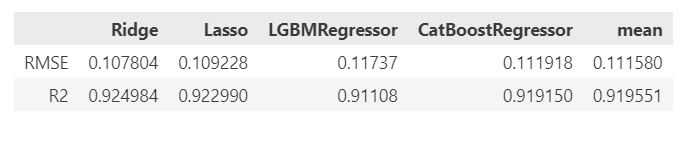

Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean
RMSE	0.106576	0.106403	0.113151	0.106451	0.108145
R2	0.926683	0.926921	0.917358	0.926855	0.924454


**1. the result improved** Remove line Bath\
 #df_upd['Bath'] = 0.225 * df['BsmtFullBath'] + (-0.0121) * df['BsmtHalfBath'] + 0.636 * df['FullBath'] + 0.343 * df['HalfBath']\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107839	0.109357	0.118549	0.110127	**0.111468**\
R2	    0.924935	0.922807	0.909285	0.921716	0.919686\

2. Remove line
    #rem_id = [250, 314, 336, 496, 584, 935, 1299, 1329] **the result got worse**\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.121717	0.123135	0.145565	0.125641	0.129015\
R2		0.909447	0.907326	0.870488	0.903515	0.897694\


3.  Change filling GarageYrBlt with YearBuilt:**the result got worse**\
 df_upd['GarageYrBlt'] = df_upd['GarageYrBlt'].fillna(df_upd['YearBuilt']) #new_3 \
 	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.108765	0.109870	0.119354	0.112227	0.112554\
R2		0.923641	0.922081	0.908048	0.918702	0.918118\

4. Round prediction to nearest 500 **the result got worse**\
pred = np.log1p(np.round(np.exp(pred) / 500) * 500)\
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107754	0.109337	0.117429	0.111843	0.111591\
R2		0.925054	0.922835	0.910991	0.919257	0.919534\

**5. the result improved** Round prediction to nearest 100 \
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107798	0.109229	0.117388	0.111896	**0.111578**\
R2		0.924993	0.922988	0.911053	0.919181	0.919554\

**6. the result improved** Changed order in OrdinalEncoder: \
oec = OrdinalEncoder(categories = [['Po', 'Fa', 'NA', 'TA', 'Gd', 'Ex']]) \
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.108610	0.109345	0.117131	0.110971	**0.111514**\
R2		0.923858	0.922824	0.911442	0.920511	0.919659\

**7. the result improved** Added new feature Neighborhoodqual\
df_upd['Neighborhoodqual'] = df_upd.groupby('Neighborhood')['OverallQual'].transform('mean')\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.105718	0.106429	0.112291	0.106418	**0.107714**\
R2		0.927858	0.926885	0.918610	0.926900	0.925063\

**8. the result improved** Added new feature Totalarea\
df_upd['Totalarea'] = df_upd['GrLivArea'] + df_upd['LotArea']\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107839	0.109302	0.115733	0.109190	**0.110516**\
R2		0.924935	0.922885	0.913544	0.923043	0.921102\

8.2 	With normalization Totalarea shows worse results:
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean
RMSE	0.107930	0.109299	0.116401	0.111180	0.111202
R2		0.924808	0.922889	0.912543	0.920212	0.920113

9. Added new 'HasGarage', 'HasBasement', 'HasFireplace'. **the result doesnt improve**\
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107306	0.108882	0.11737	0.112784	0.111586\
R2		0.925675	0.923476	0.91108	0.917893	0.919531\

10. Top for now 1+6+7+8  **Kaggle 0.13095 score**\

Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.106576	0.106403	0.113151	0.106451	0.108145\
R2		0.926683	0.926921	0.917358	0.926855	0.924454\

**11. Made changes in NormalizationTransformer() 

all results in the notebook are the same but **Kaggle 0.12924 score**\

**12. the result improved** Made changes in FillMissTransformer() regarding 'LotFrontage' and in FeatureEngineeringTransformer() regarding 'Neighborhoodqual'\
**Kaggle 0.12780 score**\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.106516	0.106345	0.114100	0.104537	0.107874\
R2	0.926765	0.927001	0.915966	0.929462	0.924799

13. the result improved here, but got worse in Kaggle (0.12927) Changed order in OrdinalEncoder: \
oec = OrdinalEncoder(categories = [['Po', 'NA', 'Fa', 'TA', 'Gd', 'Ex']]) \
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.103994	0.106276	0.112607	0.105405	0.107070\
R2	0.930193	0.927096	0.918150	0.928285	0.925931
+ change alpha in ridge alg to 22

**14. the result improved** add Elastic Net\
Ridge	Lasso	ElasticNet	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.104397	0.106421	0.105142	0.111917	0.104537	0.106483\
R2	0.929651	0.926896	0.928643	0.919151	0.929462	0.926760

### Meta models

In [ ]:
# Stack

model = XGBRegressor()

model.fit(models_train_pred, y_test)
fin_pred = model.predict(models_test_pred)

# create submission file
subm = pd.DataFrame()
subm['Id'] = t_id.astype('int')
subm['SalePrice'] = np.expm1(fin_pred)
subm.set_index('Id').to_csv('submission_all_stack_xgb.csv')

In [ ]:
# # Stack
# model = LGBMRegressor(verbose=-1)

# # params_lgbm = {'n_estimators': [400, 1000],
# #         'learning_rate': [0.1],
# #         # 'colsample_bytree': [0.7, 0.8],
# #         'max_depth': [4, 8, 12],
# #         'num_leaves': [10, 50, 100, 150],
# #         'reg_alpha': [1.1, 1.2],
# #         'reg_lambda': [1.1, 1.2],
# #         'min_split_gain': [0.3, 0.4],
# #         'subsample': [0.8, 0.9],
# #         'subsample_freq': [10, 20]}

# # params_lgbm = {'learning_rate': [0.03, 0.05, 0.1],
# #                 "max_depth": [4, 8, 12],
# #                 "num_leaves": [100, 180], 
# #                 "max_bin": [200, 300],
# #                 'n_estimators': [250, 400]}

# params_lgbm = {'learning_rate': [0.03],
#                 "max_depth": [4],
#                 "num_leaves": [100], 
#                 "max_bin": [200],
#                 'n_estimators': [250]}


# gs_alg = GridSearchCV(model, param_grid = params_lgbm, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

# gs_alg.fit(models_train_pred, y_test)
# print(gs_alg.best_estimator_)

# fin_pred = gs_alg.predict(models_test_pred)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('submission_lm_cb_stack_lgb.csv')


In [ ]:
# # Stack

# # params_cb = {'iterations': [100, 400, 600],
# #              'learning_rate': [0.03, 0.1],
# #             'depth': [4, 6, 10],
# #             'l2_leaf_reg': [1, 3, 5, 7, 9]}

# # model = cb.CatBoostRegressor(verbose=False, loss_function='RMSE')
# # grid_search_result = model.grid_search(params_cb, X=models_train_pred, y=y_test, verbose=False)

# model = cb.CatBoostRegressor(verbose=False, loss_function='RMSE', depth=4, l2_leaf_reg=1, iterations=600, learning_rate=0.03)

# model.fit(models_train_pred, y_test)
# fin_pred = model.predict(models_test_pred)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('submission_all_stack_cb.csv')

In [131]:
# output train & test preds

from datetime import datetime as dt
fname = dt.now().timestamp()

optuna_train_pred.to_csv(f'./_predictions/optuna_train_{fname :.0f}.csv')
optuna_test_pred.to_csv(f'./_predictions/optuna_test_{fname :.0f}.csv')

# optuna_train_pred.iloc[:, 3:]

In [132]:
# Stack

model = LinearRegression()
# model.fit(models_train_pred, y_test)
# fin_pred = model.predict(models_test_pred)
model.fit(optuna_train_pred.iloc[:, 3:], y_test)
fin_pred = model.predict(optuna_test_pred.iloc[:, 3:])

# create submission file
subm = pd.DataFrame()
subm['Id'] = t_id.astype('int')
subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('subm_lm_cb_lg_rf_stack_lv.csv')
subm.set_index('Id').to_csv('./_results/subm_lm_cb_xgb_stack_opt.csv')


Text(0.5, 1.0, 'SalePrice Prediction')

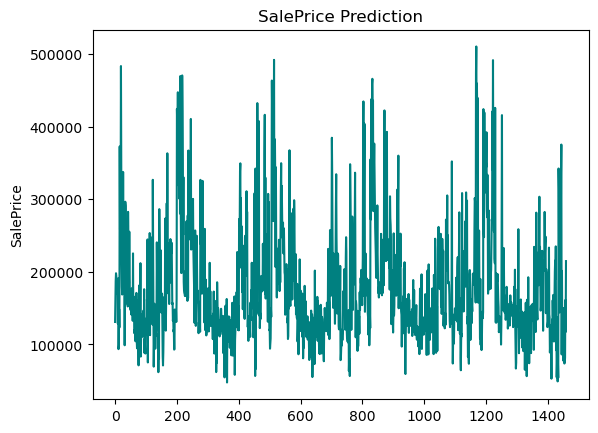

In [96]:
sns.lineplot(x=subm.index, y=subm.SalePrice, c='teal')
plt.title('SalePrice Prediction')

In [ ]:
# # Stack

# model = SVR()

# # params_svr = {'C': [1, 4, 5, 6, 10, 20], #1, 5, 10,
# #             'degree': [1, 2, 3],
# #             'coef0': [0, 1, 2, 5, 10],
# #             'kernel': ["poly", "rbf", "sigmoid"]}

# params_svr = {'C': [5], 
#             'degree': [1],
#             'coef0': [10],
#             'kernel': ["poly"]}


# # gs_alg = GridSearchCV(model, param_grid = params_svr, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

# gs_alg = GridSearchCV(model, param_grid = params_svr, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

# gs_alg.fit(models_train_pred, y_test)
# print(gs_alg.best_estimator_)

# fin_pred = gs_alg.predict(models_test_pred)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('submission_lm_cb_lg_stack_svr.csv')


In [ ]:
sns.scatterplot(x=models_train_pred['Ridge'], y=y_test)

In [ ]:
sns.scatterplot(x=models_train_pred['Ridge'], y=X_test['1stFlrSF'])

In [ ]:
sns.scatterplot(x=models_train_pred['Ridge'], y=X_test['1stFlrSF'])

In [ ]:
models_train_pred.hist(figsize=(8,8), bins=50, xlabelsize=8, ylabelsize=8)

In [ ]:
y_test.hist(figsize=(4,4), bins=50, xlabelsize=8, ylabelsize=8)

In [ ]:
sns.scatterplot(x=y_test, y=X_test['1stFlrSF'])

In [ ]:
sns.scatterplot(x=models_train_pred['Ridge'], y=y_test)

In [ ]:
sns.scatterplot(x=y_test, y=X_test['Totalarea'])

In [ ]:
X_test['Neighborhoodqual'].hist(figsize=(4,4), bins=50, xlabelsize=8, ylabelsize=8)

In [ ]:
sns.scatterplot(x=models_train_pred['Ridge'], y=y_test)

In [ ]:
subm

#### Linear models tests

Since linear models sensitive to correlation, we will remove features which have high correlation with each other. They are fixed in <b>col_tdrop_linm</b> 

What was tested:
<h5>1. - wo #1stFlrSF', '2ndFlrSF', <br>
- with MinMaxScaler()</h5><br>

1.1. <b>Lasso</b>(alpha=0.0, random_state=44) | grid search was {'alpha': np.arange(0.00, 1.0, 0.005), 'max_iter': [1000, 1200], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.124<br>
R2: 0.900 <br>
it doesn't converege<br>
kaggle: 0.15107<br>

1.2. <b>LassoCV</b><br>
return parametrs
{'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}<br>
RMSE: 0.134<br>
R2: 0.884 <br>
kaggle - 

1.3. <b>Lasso</b>(alpha=0.001, max_iter=100, random_state=44) | grid search was {'alpha': np.arange(0.001, 1.0, 0.002), 'max_iter': [100, 300, 1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.112<br>
R2: 0.918 <br>
kaggle: <b>0.14718</b>

1.4. <b>RidgeCV</b><br>
Testing performance
{'alpha_per_target': False, 'alphas': (0.1, 1.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}<br>
RMSE: 0.109<br>
R2: 0.923 <br>
kaggle: 0.14996<br>

<h5>2. - with Power Transformer ()</h5><br>
2.1. <b>Lasso</b> (alpha=0.001, max_iter=100, random_state=44) | GS was {'alpha': np.arange(0.001, 1.0, 0.002), 'max_iter': [100, 300, 1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.109<br>
R2: 0.923 <br>
kaggle: 0.14174

2.2. <b>Ridge</b>(alpha=2.95, max_iter=1000, random_state=44) | GS was {'alpha': np.arange(0.00, 3.0, 0.05), 'max_iter': [1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.109<br>
R2: 0.923 <br>
kaggle: 0.14072



<h5>3. <b>all features with Power Transformer ()</b></h5><br>
3.1. <b>Ridge</b>(alpha=2.95, max_iter=1000, random_state=44) | gs was {'alpha': np.arange(0.00, 3.0, 0.05), 'max_iter': [1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.110<br>
R2: 0.921 <br>
kaggle: <b>0.13981</b>

3.2. <b>Lasso</b>(alpha=0.001, max_iter=100, random_state=44) | gs was {'alpha': np.arange(0.001, 1.0, 0.002), 'max_iter': [100, 300, 1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.110<br>
R2: 0.921 <br>
kaggle: <b>0.14141 </b>

3.3. <b>Stack model</b> of 3.1 and 3.2<br>
LinearRegression<br>
kaggle: <b>0.13672</b><br>

3.4. <b>SVR</b>(C=10, coef0=10, degree=2, kernel='poly') | gs was {'C': [1, 5, 10, 24], 'degree': [1, 2, 3], 'coef0': [0, 5, 10], 'kernel': ["poly", "rbf", "sigmoid"]}<br>
Testing performance<br>
RMSE: 0.108<br>
R2: 0.924 <br>
kaggle 0.14329

3.5. <b>Stack model</b> of 3.1, 3.2 and 3.3 <br>
LinearRegression<br>
kaggle: <b>0.14156</b><br>

3.6. <b>Stack model</b> of 3.1, 3.2 with StandartScaler <br>
LinearRegression<br>
kaggle: <b>0.14045</b><br>